In [1]:
import os
import json
import copy
import glob 

import numpy as np
import pandas as pd
import iris
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib.patches as patches
from matplotlib.ticker import FormatStrFormatter, AutoMinorLocator, MultipleLocator
from scipy.stats import norm
import seaborn as sns
import iris.quickplot as qplt 
import scipy

Functions

In [2]:
def ext(cube,region):
    """Extract region from cube."""
    return cube.intersection(longitude=(region[0], region[2]), latitude=(region[1], region[3]))


def prepare_for_merge(cube, realization):
    """Prepare cube for merging, for ensemble statistics."""
    cube.var_name = 'n_gb_mean'
    realization_coord = iris.coords.AuxCoord(np.int32(realization), "realization", units="1")
    try:
        cube.add_aux_coord(realization_coord)
    except Exception as e:
        pass
    return cube


def area_avg_cube(cube):
    """Calculate an area-weighted average of cube."""
    if type(cube) == iris.cube.Cube:
        if not cube.coord('latitude').has_bounds():
            cube.coord('latitude').guess_bounds()
        if not cube.coord('longitude').has_bounds():
            cube.coord('longitude').guess_bounds()
        grid_areas = iris.analysis.cartography.area_weights(cube)
        
        new_cube = cube.collapsed(['longitude', 'latitude'], iris.analysis.MEAN, weights=grid_areas)
    
    else:
        raise TypeError('Function only accepts cubes')
    
    return new_cube

def get_ensemble_statistics_2(cube_dict):
    cubes_c1 = cube_dict['C1-IMP-Ren']
    cubes_c2 = cube_dict['C2-IMP-Neg']
    cubes_c3 = cube_dict['C3-IMP-GS']
    
    stats = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}}
    for p in cubes_c1:
        realization = 0
        for c1 in cubes_c1[p]:
            c1 = prepare_for_merge(c1, realization)
            realization += 1
        realization = 0
        for c2 in cubes_c2[p]:
            c2 = prepare_for_merge(c2, realization)
            realization += 1
        realization = 0
        for c3 in cubes_c3[p]:
            c3 = prepare_for_merge(c3, realization)
            realization += 1

        # this just deletes any attributes that don't match between cubes in the cubelist
        # which removes errors whilst merging
        iris.util.equalise_attributes(cubes_c1[p])
        iris.util.equalise_attributes(cubes_c2[p])
        iris.util.equalise_attributes(cubes_c3[p])

        mm_cube_c1 = cubes_c1[p].merge_cube()
        mm_cube_c2 = cubes_c2[p].merge_cube()
        mm_cube_c3 = cubes_c3[p].merge_cube()

        # Means
        c1_mean = mm_cube_c1.collapsed('realization', iris.analysis.MEAN)
        c2_mean = mm_cube_c2.collapsed('realization', iris.analysis.MEAN)
        c3_mean = mm_cube_c3.collapsed('realization', iris.analysis.MEAN)

        # Medians
        c1_median = mm_cube_c1.collapsed('realization', iris.analysis.MEDIAN)
        c2_median = mm_cube_c2.collapsed('realization', iris.analysis.MEDIAN)
        c3_median = mm_cube_c3.collapsed('realization', iris.analysis.MEDIAN)

        # Maxes
        c1_max = mm_cube_c1.collapsed('realization', iris.analysis.MAX)
        c2_max = mm_cube_c2.collapsed('realization', iris.analysis.MAX)
        c3_max = mm_cube_c3.collapsed('realization', iris.analysis.MAX)

        # Mins
        c1_min = mm_cube_c1.collapsed('realization', iris.analysis.MIN)
        c2_min = mm_cube_c2.collapsed('realization', iris.analysis.MIN)
        c3_min = mm_cube_c3.collapsed('realization', iris.analysis.MIN)

        stats['C1-IMP-Ren'][p] = [c1_mean, c1_median, c1_max, c1_min]
        stats['C2-IMP-Neg'][p] = [c2_mean, c2_median, c2_max, c2_min]
        stats['C3-IMP-GS'][p] = [c3_mean, c3_median, c3_max, c3_min]

    return stats

def get_regional_stats_2(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][0], region))
        area_mean['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][0], region))
        area_mean['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][0], region))
        
        area_med['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][1], region))
        area_med['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][1], region))
        area_med['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][1], region))
        
        area_max['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][2], region))
        area_max['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][2], region))
        area_max['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][2], region))
        
        area_min['c1'][p] = area_avg_cube(ext(cubes['C1-IMP-Ren'][p][3], region))
        area_min['c2'][p] = area_avg_cube(ext(cubes['C2-IMP-Neg'][p][3], region))
        area_min['c3'][p] = area_avg_cube(ext(cubes['C3-IMP-GS'][p][3], region))
        
    return [area_mean, area_med, area_max, area_min]


def get_regional_stats_frac_2(cubes, region):
    area_mean = {'c1':{}, 'c2':{}, 'c3':{}}
    area_med = {'c1':{}, 'c2':{}, 'c3':{}}
    area_max = {'c1':{}, 'c2':{}, 'c3':{}}
    area_min = {'c1':{}, 'c2':{}, 'c3':{}}

    for p in cubes['C1-IMP-Ren']:
        area_mean['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][0][:, :5]), region))
        area_mean['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][0][:, :5]), region))
        area_mean['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][0][:, :5]), region))
        
        area_med['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][1][:, :5]), region))
        area_med['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][1][:, :5]), region))
        area_med['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][1][:, :5]), region))
        
        area_max['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][2][:, :5]), region))
        area_max['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][2][:, :5]), region))
        area_max['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][2][:, :5]), region))
        
        area_min['c1'][p] = area_avg_cube(ext(np.sum(cubes['C1-IMP-Ren'][p][3][:, :5]), region))
        area_min['c2'][p] = area_avg_cube(ext(np.sum(cubes['C2-IMP-Neg'][p][3][:, :5]), region))
        area_min['c3'][p] = area_avg_cube(ext(np.sum(cubes['C3-IMP-GS'][p][3][:, :5]), region))
        
    return [area_mean, area_med, area_max, area_min]

def get_ensemble_statistics(cube_dict):
    cubes_c1 = cube_dict['C1-IMP-Ren']
    cubes_c2 = cube_dict['C2-IMP-Neg']
    cubes_c3 = cube_dict['C3-IMP-GS']
    cubes_c4 = cube_dict['ssprcmip_ssp534_over']
    
    stats = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}, 'ssprcmip_ssp534_over': {}}
    for p in cubes_c1:
        realization = 0
        for (c1, c2, c3, c4) in zip(cubes_c1[p], cubes_c2[p], cubes_c3[p], cubes_c4[p]):
            c1 = prepare_for_merge(c1, realization)
            c2 = prepare_for_merge(c2, realization)
            c3 = prepare_for_merge(c3, realization)
            c4 = prepare_for_merge(c4, realization)
            realization += 1

        # this just deletes any attributes that don't match between cubes in the cubelist
        # which removes errors whilst merging
        iris.util.equalise_attributes(cubes_c1[p])
        iris.util.equalise_attributes(cubes_c2[p])
        iris.util.equalise_attributes(cubes_c3[p])
        iris.util.equalise_attributes(cubes_c4[p])

        mm_cube_c1 = cubes_c1[p].merge_cube()
        mm_cube_c2 = cubes_c2[p].merge_cube()
        mm_cube_c3 = cubes_c3[p].merge_cube()
        mm_cube_c4 = cubes_c4[p].merge_cube()

        # Means
        c1_mean = mm_cube_c1.collapsed('realization', iris.analysis.MEAN)
        c2_mean = mm_cube_c2.collapsed('realization', iris.analysis.MEAN)
        c3_mean = mm_cube_c3.collapsed('realization', iris.analysis.MEAN)
        c4_mean = mm_cube_c4.collapsed('realization', iris.analysis.MEAN)

        # Medians
        c1_median = mm_cube_c1.collapsed('realization', iris.analysis.MEDIAN)
        c2_median = mm_cube_c2.collapsed('realization', iris.analysis.MEDIAN)
        c3_median = mm_cube_c3.collapsed('realization', iris.analysis.MEDIAN)
        c4_median = mm_cube_c4.collapsed('realization', iris.analysis.MEDIAN)

        # Maxes
        c1_max = mm_cube_c1.collapsed('realization', iris.analysis.MAX)
        c2_max = mm_cube_c2.collapsed('realization', iris.analysis.MAX)
        c3_max = mm_cube_c3.collapsed('realization', iris.analysis.MAX)
        c4_max = mm_cube_c4.collapsed('realization', iris.analysis.MAX)

        # Mins
        c1_min = mm_cube_c1.collapsed('realization', iris.analysis.MIN)
        c2_min = mm_cube_c2.collapsed('realization', iris.analysis.MIN)
        c3_min = mm_cube_c3.collapsed('realization', iris.analysis.MIN)
        c4_min = mm_cube_c4.collapsed('realization', iris.analysis.MIN)

        stats['C1-IMP-Ren'][p] = [c1_mean, c1_median, c1_max, c1_min]
        stats['C2-IMP-Neg'][p] = [c2_mean, c2_median, c2_max, c2_min]
        stats['C3-IMP-GS'][p] = [c3_mean, c3_median, c3_max, c3_min]
        stats['ssprcmip_ssp534_over'][p] = [c4_mean, c4_median, c4_max, c4_min]

    return stats

def get_regional_stats(cubes, region):
    cubes = copy.deepcopy(cubes)
    for scenario in cubes:
        for p in cubes[scenario]:
            for i, _ in enumerate(cubes[scenario][p]):
                cubes[scenario][p][i] = area_avg_cube(ext(cubes[scenario][p][i], region))
        
    return cubes


def get_regional_stats_frac(cubes, region):
    cubes = copy.deepcopy(cubes)
    for scenario in cubes:
        for p in cubes[scenario]:
            for i, _ in enumerate(cubes[scenario][p]):
                cubes[scenario][p][i] = area_avg_cube(ext(np.sum(cubes[scenario][p][i][:, :5]), region))
        
    return cubes


# time series plots
def plot_single_timeseries(area_list, conv, region, title=None, ylabel=None):
    font = {
        'family': 'sans-serif',
        'weight': 'normal',
        'size': 12,
        }

    matplotlib.rc('font', **font)
    area, area_med, area_max, area_min = area_list
    time = np.arange(1990, 2110, 10)
    decs = len(time)

    nrows = 1
    ncols = 6
    X = [ ((1,5)), (6,6)]
    fig = plt.figure(figsize=(8,6))

    ### --- subfig 1
    sub1 = fig.add_subplot(nrows, ncols, X[0])
    sub1.set_title(title)
    sub1.set_ylabel(ylabel)
    sub1.set_xlim(np.min(time), 2105)
    #sub.set_ylim(-3,2)
    # c1
    sub1.plot(time, area_med['c1']['0.5'][-decs:].data*conv - 295.59, 'blue', linewidth=2, label=f'C1: IMP-Ren')
    sub1.fill_between(time, area_med['c1']['0.01'][-decs:].data*conv - 295.59, area_med['c1']['0.99'][-decs:].data*conv - 295.59, color='blue', alpha=0.2)
    # c2
    sub1.plot(time, area_med['c2']['0.5'][-decs:].data*conv - 295.59, 'red', linewidth=2, label=f'C2: IMP-Neg')
    sub1.fill_between(time, area_med['c2']['0.01'][-decs:].data*conv - 295.59, area_med['c2']['0.99'][-decs:].data*conv - 295.59, color='red', alpha=0.2)
    # c3
    sub1.plot(time, area['c3']['0.5'][-decs:].data*conv - 295.59, 'cyan', linewidth=3, label=f'C3: IMP-GS')
    sub1.fill_between(time, area['c3']['0.01'][-decs:].data*conv - 295.59, area['c3']['0.99'][-decs:].data*conv - 295.59, color='cyan', alpha=0.2)

    sub1.legend(loc="upper left",frameon=False,prop={'size': 10})

    ### --- subfig 2
    sub2 = fig.add_subplot(nrows, ncols, X[1])
    sub2.set_xlim(0,4)
    sub2.set_xticks([1, 2, 3])
    sub2.set_xticklabels(["C1", "C2", "C3"])
    sub2.set_yticklabels("")

    # c1
    sub2.plot([1, 1], [area_min['c1']['0.5'][-1].data*conv - 295.59, area_max['c1']['0.5'][-1].data*conv - 295.59], 'blue', lw=10, alpha=0.2)
    sub2.scatter(1, np.double(area_med['c1']['0.5'][-1].data*conv - 295.59), marker=',', color='blue')
    # c2
    sub2.plot([2, 2], [area_min['c2']['0.5'][-1].data*conv - 295.59, area_max['c2']['0.5'][-1].data*conv - 295.59], 'red', lw=10, alpha=0.2)
    sub2.scatter(2, np.double(area_med['c2']['0.5'][-1].data*conv - 295.59), marker=',', color='red')
    # c3
    sub2.plot([3, 3], [area_min['c3']['0.5'][-1].data*conv - 295.59, area_max['c3']['0.5'][-1].data*conv - 295.59], 'cyan', lw=10, alpha=0.2)
    sub2.scatter(3, np.double(area['c3']['0.5'][-1].data*conv - 295.59), marker=',', color='cyan')

    # set y-limits for both subplots (makes sure that subplots have equal y-axis limits and that that it fits the uncertainty ranges of both subplots)
    if (abs(np.ptp(sub1.get_ylim())) > abs(np.ptp(sub2.get_ylim()))):   # if first subplot's ylim greater than the second
        ylim = sub1.get_ylim()
    else:
        ylim = sub2.get_ylim()
    sub1.set_ylim(ylim)
    sub2.set_ylim(ylim)
    
    fname = area['c1']['0.5'].var_name
    plt.savefig(f'{os.getcwd()[:-9]}/plots/{fname}_{region}_CSSP.png', dpi=500)

Load data

In [13]:
# Gets parent directory
fair_dict_path = '/home/h03/hadea/roses/u-bd604_gmtchange_es_2300/bin/fair_2300_dict.json'
data_path = "/scratch/hadea/imogen_post/imogen6/u-bd604_gmtchange_es_2300_ens_new"
ssp_path = "/scratch/hadea/imogen_post/imogen6/u-bd604_gmtchange_es_ssp_ens"
ssp_dict_path = "/home/h03/hadea/roses/u-bd604_gmtchange_es_ssp/bin/fairssp_dict.json"

with open(fair_dict_path) as f:
    fair_dict = json.load(f)
    
with open(ssp_dict_path) as f:
    ssp_dict = json.load(f)

percentiles = ['0.0', '0.01', '0.05', '0.25', '0.5', '0.75', '0.95', '0.99', '1.0']
scenarios = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS']
variables = ['t1p5m_gb', 'precip', 'npp_n_gb', 'frac']
t1p5m_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}, 'ssprcmip_ssp534_over': {}}
precip_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}, 'ssprcmip_ssp534_over': {}}
npp_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}, 'ssprcmip_ssp534_over': {}}
frac_cubes = {'C1-IMP-Ren':{}, 'C2-IMP-Neg':{}, 'C3-IMP-GS':{}, 'ssprcmip_ssp534_over': {}}

for root, dirs, files in os.walk(data_path):
    for file in files:
        for scenario in scenarios:
            for p in percentiles:
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[0]}_ens.nc')):
                    t1p5m_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[1]}_ens.nc')):
                    precip_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[2]}_ens.nc')):
                    npp_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                if (file.startswith(f'{fair_dict[scenario][p]}_{scenario}') and 
                    file.endswith(f'{variables[3]}_ens.nc')):
                    frac_cubes[scenario][p] = iris.cube.CubeList(sorted(iris.load(data_path + '/' + file), key=(lambda cube: cube.attributes['source'])))
                    
# ssp_scens = ['ssprcmip_ssp534_over']
# for root, dirs, files in os.walk(ssp_path):
#     for file in files:
#         for scenario in ssp_scens:
#             for p in percentiles:
#                 if (file.startswith(f'{ssp_dict[scenario][p]}_{scenario}') and 
#                     file.endswith(f'{variables[0]}_ens.nc')):
#                     t1p5m_cubes[scenario][p] = iris.load(ssp_path + '/' + file)
#                 if (file.startswith(f'{ssp_dict[scenario][p]}_{scenario}') and 
#                     file.endswith(f'{variables[1]}_ens.nc')):
#                     precip_cubes[scenario][p] = iris.load(ssp_path + '/' + file)
#                 if (file.startswith(f'{ssp_dict[scenario][p]}_{scenario}') and 
#                     file.endswith(f'{variables[2]}_ens.nc')):
#                     npp_cubes[scenario][p] = iris.load(ssp_path + '/' + file)
#                 if (file.startswith(f'{ssp_dict[scenario][p]}_{scenario}') and 
#                     file.endswith(f'{variables[3]}_ens.nc')):
#                     frac_cubes[scenario][p] = iris.load(ssp_path + '/' + file)

# scenarios = ['C1-IMP-Ren', 'C2-IMP-Neg', 'C3-IMP-GS', 'ssprcmip_ssp534_over']

Ensure time bounds are consistent and shorten SSP to length of IMPs

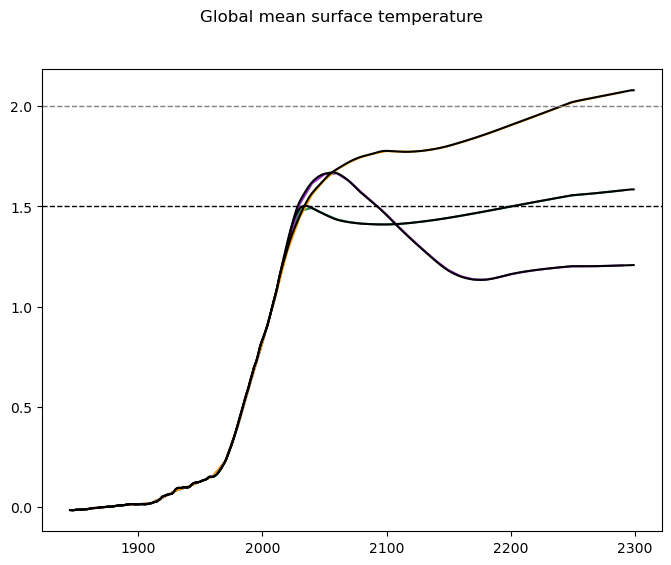

553


In [14]:
# %%capture
# FaIR input vs JULES output comparison
path = '/home/h03/hadea/roses/u-bd604_gmtchange_es_2300/bin/imogen_fair_2300'

ren_list = glob.glob(path + '/*C1-IMP-Ren_temp.dat')
neg_list = glob.glob(path + '/*C2-IMP-Neg_temp.dat')
gs_list = glob.glob(path + '/*C3-IMP-GS_temp.dat')

ren = []
neg = []
gs = []

for (r, n, g) in zip(ren_list, neg_list, gs_list):
    df = pd.read_csv(r, delimiter=' ', names=['year', 'val'])
    df.drop('year', axis=1, inplace=True)
    df.columns = [r[69:].split('_')[0]]
    ren.append(df)
    
    df = pd.read_csv(n, delimiter=' ', names=['year', 'val'])
    df.drop('year', axis=1, inplace=True)
    df.columns = [n[69:].split('_')[0]]
    neg.append(df)
    
    df = pd.read_csv(g, delimiter=' ', names=['year', 'val'])
    df.drop('year', axis=1, inplace=True)
    df.columns = [g[69:].split('_')[0]]
    gs.append(df)

ren = pd.concat(ren, axis=1)
neg = pd.concat(neg, axis=1)
gs = pd.concat(gs, axis=1)

time = np.arange(1850, 2300, 10)

fig = plt.figure(figsize=(8, 6))

ax = fig.add_subplot(111)
plt.suptitle('Global mean surface temperature')

# for cube in t1p5m_cubes['C1-IMP-Ren']['0.5']:
#     ax.plot(time, area_avg_cube(cube).data - area_avg_cube(cube[:5].collapsed('time', iris.analysis.MEAN)).data, color='seagreen', alpha=0.2)
# for cube in t1p5m_cubes['C2-IMP-Neg']['0.5']:
#     ax.plot(time, area_avg_cube(cube).data - area_avg_cube(cube[:5].collapsed('time', iris.analysis.MEAN)).data, color='darkorchid', alpha=0.2)
# for cube in t1p5m_cubes['C3-IMP-GS']['0.5']:
#     ax.plot(time, area_avg_cube(cube).data - area_avg_cube(cube[:5].collapsed('time', iris.analysis.MEAN)).data, color='orange', alpha=0.2)
    
def moving_average(x, w, decs):
    arr = np.ones(decs)
    for i in range(decs):
        arr[i] = np.mean(x[i*w:i*w+w])

    return arr

time = np.arange(1850, 2300, 10)
decs = len(time)

member = fair_dict['C1-IMP-Ren']['0.5']
ax.plot(time, moving_average(ren[member][-455:].values, 10, decs), color='seagreen')
member = fair_dict['C2-IMP-Neg']['0.5']
ax.plot(time, moving_average(neg[member][-455:].values, 10, decs), color='darkorchid')
member = fair_dict['C3-IMP-GS']['0.5']
ax.plot(time, moving_average(gs[member][-455:].values, 10, decs), color='orange')
time = np.arange(1845, 2300)
member = fair_dict['C1-IMP-Ren']['0.5']
ax.plot(time, ren[member][-455:], color='black')
member = fair_dict['C2-IMP-Neg']['0.5']
ax.plot(time, neg[member][-455:], color='black')
member = fair_dict['C3-IMP-GS']['0.5']
ax.plot(time, gs[member][-455:], color='black')
    
ax.axhline(1.5, linestyle='--', color='black', lw=1)
ax.axhline(2.0, linestyle='--', color='gray', lw=1)
plt.show()
# plt.savefig('../paper_plots/input_vs_output_temp.png', dpi=400)

c1_50 = fair_dict['C1-IMP-Ren']['0.5']
c2_50 = fair_dict['C2-IMP-Neg']['0.5']
c3_50 = fair_dict['C3-IMP-GS']['0.5']

print(len(ren[c1_50].values))

ren_temp = moving_average(ren[c1_50][-455:].values, 10, decs)[-30:]
neg_temp = moving_average(neg[c2_50][-455:].values, 10, decs)[-30:]
gs_temp = moving_average(gs[c3_50][-455:].values, 10, decs)[-30:]



In [15]:
gtemp_dict ={
    'C1-IMP-Ren': {},
    'C2-IMP-Neg': {},
    'C3-IMP-GS': {},
}
for scen in scenarios:
    for p in percentiles:
        gtemp_dict['C1-IMP-Ren'][p] = moving_average(ren[fair_dict[scen][p]][-455:].values, 10, decs)
        gtemp_dict['C2-IMP-Neg'][p] = moving_average(neg[fair_dict[scen][p]][-455:].values, 10, decs)
        gtemp_dict['C3-IMP-GS'][p] = moving_average(gs[fair_dict[scen][p]][-455:].values, 10, decs)

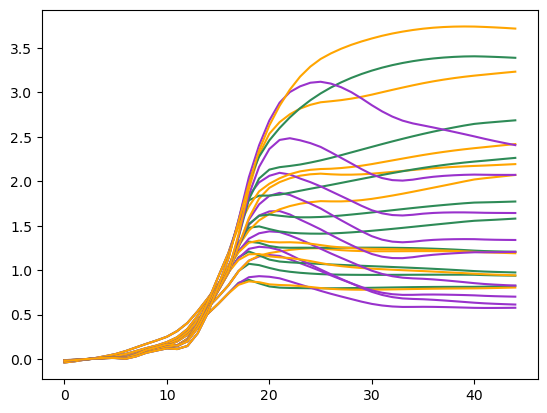

In [16]:
for p in percentiles:
    plt.plot(gtemp_dict['C1-IMP-Ren'][p], color='seagreen')
    plt.plot(gtemp_dict['C2-IMP-Neg'][p], color='darkorchid')
    plt.plot(gtemp_dict['C3-IMP-GS'][p], color='orange')

In [17]:
time = np.arange(2000, 2300, 10)
decs = len(time)

In [18]:
time_coord = t1p5m_cubes['C1-IMP-Ren']['0.01'][0].coord('time')
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            if not scen == 'ssprcmip_ssp534_over':
                t1p5m_cubes[scen][p][i].remove_coord('time')
                t1p5m_cubes[scen][p][i].add_dim_coord(time_coord, 0)

                precip_cubes[scen][p][i].remove_coord('time')
                precip_cubes[scen][p][i].add_dim_coord(time_coord, 0)
                
                npp_cubes[scen][p][i].remove_coord('time') 
                npp_cubes[scen][p][i].add_dim_coord(time_coord, 0)
                
                frac_cubes[scen][p][i].remove_coord('time')
                frac_cubes[scen][p][i].add_dim_coord(time_coord, 0)
                
                
# for p in percentiles:
#     for i, model in enumerate(t1p5m_cubes['ssprcmip_ssp534_over'][p]):
#         t1p5m_cubes['ssprcmip_ssp534_over'][p][i] = t1p5m_cubes['ssprcmip_ssp534_over'][p][i][15:45]
#         precip_cubes['ssprcmip_ssp534_over'][p][i] = precip_cubes['ssprcmip_ssp534_over'][p][i][15:45]
#         npp_cubes['ssprcmip_ssp534_over'][p][i] = npp_cubes['ssprcmip_ssp534_over'][p][i][15:45]
#         frac_cubes['ssprcmip_ssp534_over'][p][i] = frac_cubes['ssprcmip_ssp534_over'][p][i][15:45]

##### Pop problematic models from cubelists:

- NorESM2-LM
- KACE-1-0-G
- E3SM-1-0

In [19]:
for scen in scenarios:
    for p in percentiles:
        for i, model in enumerate(t1p5m_cubes[scen][p]):
            if model.attributes['source'].split('/')[6].split('_')[0] in ['NorESM2-LM', 'KACE-1-0-G', 'E3SM-1-0']: # FIO-ESM only in temporarily, as is missing for NPP only
                t1p5m_cubes[scen][p].pop(i)
                precip_cubes[scen][p].pop(i)
                frac_cubes[scen][p].pop(i)
                npp_cubes[scen][p].pop(i)    

Define regions

In [20]:
# define region. Allows running notebook for different regions
region = {
    "amazon": [-90,-40,-15,10],
    "siberia": [45, 45, 135, 80],
    "global": [-180, -90, 180, 90]
}

In [21]:
%%capture
npp_stats = get_ensemble_statistics_2(npp_cubes)
t1p5m_stats = get_ensemble_statistics_2(t1p5m_cubes)
frac_stats = get_ensemble_statistics_2(frac_cubes)

In [22]:
%%capture
npp_area_list_amazon_stats = get_regional_stats_2(npp_stats, region=region['amazon'])
t1p5m_area_list_amazon_stats = get_regional_stats_2(t1p5m_stats, region=region['amazon'])
frac_area_list_amazon_stats = get_regional_stats_frac_2(frac_stats, region=region['amazon'])

npp_area_list_siberia_stats = get_regional_stats_2(npp_stats, region=region['siberia'])
t1p5m_area_list_siberia_stats = get_regional_stats_2(t1p5m_stats, region=region['siberia'])
frac_area_list_siberia_stats = get_regional_stats_frac_2(frac_stats, region=region['siberia'])

t1p5m_area_list_global_stats = get_regional_stats_2(t1p5m_stats, region=region['global'])

Get all ESM responses for Amazon and Siberia

In [23]:
%%capture
npp_area_list_amazon = get_regional_stats(npp_cubes, region=region['amazon'])
t1p5m_area_list_amazon = get_regional_stats(t1p5m_cubes, region=region['amazon'])
precip_area_list_amazon = get_regional_stats(precip_cubes, region=region['amazon'])
frac_area_list_amazon = get_regional_stats_frac(frac_cubes, region=region['amazon'])

npp_area_list_siberia = get_regional_stats(npp_cubes, region=region['siberia'])
t1p5m_area_list_siberia = get_regional_stats(t1p5m_cubes, region=region['siberia'])
precip_area_list_siberia = get_regional_stats(precip_cubes, region=region['siberia'])
frac_area_list_siberia = get_regional_stats_frac(frac_cubes, region=region['siberia'])

Calculate region areas

In [24]:
# calculate amazon grid area
area_cube = iris.load_cube(f'{os.getcwd()[:-9]}/gmtchange_es_area.nc')
amazon_area = np.sum(ext(area_cube, region['amazon']).data) * 1e6 # km2 = m2
siberia_area = np.sum(ext(area_cube, region['siberia']).data) * 1e6 # km2 = m2
amazon_conv = amazon_area / 1e12 # conv: kg m-2 y-1 -> PgC
siberia_conv = siberia_area / 1e12 # conv: kg m-2 y-1 -> PgC

Calculate regional temp anomaly

In [25]:
%%capture
# Calculate regional temperature anomaly 1850-1900
temp_mean_amazon = copy.deepcopy(t1p5m_area_list_amazon)
for scen in scenarios:
    for p in percentiles:
        for i, _ in enumerate(temp_mean_amazon[scen][p]):
            temp_mean_amazon[scen][p][i] = temp_mean_amazon[scen][p][i] - temp_mean_amazon[scen][p][i][:5].collapsed('time', iris.analysis.MEAN)
        
temp_mean_siberia = copy.deepcopy(t1p5m_area_list_siberia)
for scen in scenarios:
    for p in percentiles:
        for i, _ in enumerate(temp_mean_siberia[scen][p]):
            temp_mean_siberia[scen][p][i] = temp_mean_siberia[scen][p][i] - temp_mean_siberia[scen][p][i][:5].collapsed('time', iris.analysis.MEAN)

Plot all scenarios, percentiles, all models

In [26]:
frac_amazon = copy.deepcopy(frac_area_list_amazon)
temp_amazon = copy.deepcopy(temp_mean_amazon) # Anomaly
precip_amazon = copy.deepcopy(precip_area_list_amazon)
npp_amazon = copy.deepcopy(npp_area_list_amazon)

frac_siberia = copy.deepcopy(frac_area_list_siberia)
temp_siberia = copy.deepcopy(temp_mean_siberia) # Anomaly
precip_siberia = copy.deepcopy(precip_area_list_siberia)
npp_siberia = copy.deepcopy(npp_area_list_siberia)

Calculate 2000-2020 mean (for present day baseline period)

In [27]:
%%capture
# Calculate stats to get ensemble mean
npp_stats_amazon = get_ensemble_statistics_2(npp_area_list_amazon)
frac_stats_amazon = get_ensemble_statistics_2(frac_area_list_amazon)
npp_stats_siberia = get_ensemble_statistics_2(npp_area_list_siberia)
frac_stats_siberia = get_ensemble_statistics_2(frac_area_list_siberia)

# Calculate mean over all scenarios for 50th percentile
npp_baseline_amazon = np.mean([npp_stats_amazon[scen]['0.5'][0][15:17].data for scen in scenarios])
frac_baseline_amazon = np.mean([np.sum(frac_stats_amazon[scen]['0.5'][0][15:17, :5].data, axis=1) for scen in scenarios])
npp_baseline_siberia = np.mean([npp_stats_siberia[scen]['0.5'][0][15:17].data for scen in scenarios])
frac_baseline_siberia = np.mean([np.sum(frac_stats_siberia[scen]['0.5'][0][15:17, :5].data, axis=1) for scen in scenarios])

print(npp_baseline_amazon)

Extract models which show tail risk of dropping below present-day basline

In [28]:
print(f'Frac baseline amazon: {frac_baseline_amazon}')
print(f'Frac baseline siberia: {frac_baseline_siberia}')
print(f'NPP baseline amazon: {npp_baseline_amazon*amazon_conv}')
print(f'NPP baseline siberia: {npp_baseline_siberia*siberia_conv}')

Frac baseline amazon: 0.40491834031891716
Frac baseline siberia: 0.2549000854052015
NPP baseline amazon: 9.834009253483385
NPP baseline siberia: 2.5685072983979635


In [18]:
c1_frac_models = []
c2_frac_models = []
c3_frac_models = []
ssp_frac_models = []

c1_npp_models = []
c2_npp_models = []
c3_npp_models = []
ssp_npp_models = []

c1_temp_frac_models = []
c2_temp_frac_models = []
c3_temp_frac_models = []
ssp_temp_frac_models = []

c1_temp_npp_models = []
c2_temp_npp_models = []
c3_temp_npp_models = []
ssp_temp_npp_models = []

c1_precip_frac_models = []
c2_precip_frac_models = []
c3_precip_frac_models = []
ssp_precip_frac_models = []

c1_precip_npp_models = []
c2_precip_npp_models = []
c3_precip_npp_models = []
ssp_precip_npp_models = []

### NOT models ###

c1_frac_models_not = []
c2_frac_models_not = []
c3_frac_models_not = []
ssp_frac_models_not = []

c1_npp_models_not = []
c2_npp_models_not = []
c3_npp_models_not = []
ssp_npp_models_not = []

c1_temp_frac_models_not = []
c2_temp_frac_models_not = []
c3_temp_frac_models_not = []
ssp_temp_frac_models_not = []

c1_temp_npp_models_not = []
c2_temp_npp_models_not = []
c3_temp_npp_models_not = []
ssp_temp_npp_models_not = []

c1_precip_frac_models_not = []
c2_precip_frac_models_not = []
c3_precip_frac_models_not = []
ssp_precip_frac_models_not = []

c1_precip_npp_models_not = []
c2_precip_npp_models_not = []
c3_precip_npp_models_not = []
ssp_precip_npp_models_not = []

for scen in scenarios:
    for j, p in enumerate(percentiles):
        for i, _ in enumerate(temp_mean_amazon[scen][p]):
            # Select fracs that come in below present day threshold in 2100
            if np.sum(frac_amazon[scen][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    # print(f'\nvariable, frac')
                    # print(f'scenario, {scen}')
                    # print(f'perc, {p}')
                    # model = frac_amazon[scen][p][i].attributes['source'].split('/')[6].split('_')[0]
                    # print(f'model, {model}')
                    
                    c1_frac_models.append(frac_amazon[scen][p][i])
                    c1_temp_frac_models.append(temp_amazon[scen][p][i])
                    c1_precip_frac_models.append(precip_amazon[scen][p][i])
                    
                if scen == 'C2-IMP-Neg':
                    # print(f'\nvariable, frac')
                    # print(f'scenario, {scen}')
                    # print(f'perc, {p}')
                    # model = frac_amazon[scen][p][i].attributes['source'].split('/')[6].split('_')[0]
                    # print(f'model, {model}')
                    
                    c2_frac_models.append(frac_amazon[scen][p][i])
                    c2_temp_frac_models.append(temp_amazon[scen][p][i])
                    c2_precip_frac_models.append(precip_amazon[scen][p][i])
                    
                if scen == 'C3-IMP-GS':
                    # print(f'\nvariable, frac')
                    # print(f'scenario, {scen}')
                    # print(f'perc, {p}')
                    # model = frac_amazon[scen][p][i].attributes['source'].split('/')[6].split('_')[0]
                    # print(f'model, {model}')
                    
                    c3_frac_models.append(frac_amazon[scen][p][i])
                    c3_temp_frac_models.append(temp_amazon[scen][p][i])
                    c3_precip_frac_models.append(precip_amazon[scen][p][i])
                    
                if scen == 'ssprcmip_ssp534_over':
                    ssp_frac_models.append(frac_amazon[scen][p][i])
                    ssp_temp_frac_models.append(temp_amazon[scen][p][i])
                    ssp_precip_frac_models.append(precip_amazon[scen][p][i])
                    
            else:
                if scen == 'C1-IMP-Ren':
                    c1_frac_models_not.append(frac_amazon[scen][p][i])
                    c1_temp_frac_models_not.append(temp_amazon[scen][p][i])
                    c1_precip_frac_models_not.append(precip_amazon[scen][p][i])
                    
                if scen == 'C2-IMP-Neg':
                    c2_frac_models_not.append(frac_amazon[scen][p][i])
                    c2_temp_frac_models_not.append(temp_amazon[scen][p][i])
                    c2_precip_frac_models_not.append(precip_amazon[scen][p][i])
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_models_not.append(frac_amazon[scen][p][i])
                    c3_temp_frac_models_not.append(temp_amazon[scen][p][i])
                    c3_precip_frac_models_not.append(precip_amazon[scen][p][i])
                    
                if scen == 'ssprcmip_ssp534_over':
                    ssp_frac_models_not.append(frac_amazon[scen][p][i])
                    ssp_temp_frac_models_not.append(temp_amazon[scen][p][i])
                    ssp_precip_frac_models_not.append(precip_amazon[scen][p][i])
                    
            # Select NPP that comes in below present day threshold in 2100
            if npp_amazon[scen][p][i][25].data < npp_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    # print(f'\nvariable, npp')
                    # print(f'scenario, {scen}')
                    # print(f'perc, {p}')
                    # model = npp_amazon[scen][p][i].attributes['source'].split('/')[6].split('_')[0]
                    # print(f'model, {model}')
                    
                    c1_npp_models.append(npp_amazon[scen][p][i])
                    c1_temp_npp_models.append(temp_amazon[scen][p][i])
                    c1_precip_npp_models.append(precip_amazon[scen][p][i])
                    
                if scen == 'C2-IMP-Neg':
                    # print(f'\nvariable, npp')
                    # print(f'scenario, {scen}')
                    # print(f'perc, {p}')
                    # model = npp_amazon[scen][p][i].attributes['source'].split('/')[6].split('_')[0]
                    # print(f'model, {model}')
                    
                    c2_npp_models.append(npp_amazon[scen][p][i])
                    c2_temp_npp_models.append(temp_amazon[scen][p][i])
                    c2_precip_npp_models.append(precip_amazon[scen][p][i])
                    
                if scen == 'C3-IMP-GS':
                    # print(f'\nvariable, npp')
                    # print(f'scenario, {scen}')
                    # print(f'perc, {p}')
                    # model = npp_amazon[scen][p][i].attributes['source'].split('/')[6].split('_')[0]
                    # print(f'model, {model}')
                    
                    c3_npp_models.append(npp_amazon[scen][p][i])
                    c3_temp_npp_models.append(temp_amazon[scen][p][i])
                    c3_precip_npp_models.append(precip_amazon[scen][p][i])
                    
                if scen == 'ssprcmip_ssp534_over':
                    ssp_npp_models.append(npp_amazon[scen][p][i])
                    ssp_temp_npp_models.append(temp_amazon[scen][p][i])
                    ssp_precip_npp_models.append(precip_amazon[scen][p][i])
                    
            else:
                if scen == 'C1-IMP-Ren':
                    c1_npp_models_not.append(npp_amazon[scen][p][i])
                    c1_temp_npp_models_not.append(temp_amazon[scen][p][i])
                    c1_precip_npp_models_not.append(precip_amazon[scen][p][i])
                    
                if scen == 'C2-IMP-Neg':
                    c2_npp_models_not.append(npp_amazon[scen][p][i])
                    c2_temp_npp_models_not.append(temp_amazon[scen][p][i])
                    c2_precip_npp_models_not.append(precip_amazon[scen][p][i])
                    
                if scen == 'C3-IMP-GS':
                    c3_npp_models_not.append(npp_amazon[scen][p][i])
                    c3_temp_npp_models_not.append(temp_amazon[scen][p][i])
                    c3_precip_npp_models_not.append(precip_amazon[scen][p][i])
                    
                if scen == 'ssprcmip_ssp534_over':
                    ssp_npp_models_not.append(npp_amazon[scen][p][i])
                    ssp_temp_npp_models_not.append(temp_amazon[scen][p][i])
                    ssp_precip_npp_models_not.append(precip_amazon[scen][p][i])
                    
                    

**We want to look at whether the models that surpass the baseline are particularly hot/dry.**

Calculate the global temp/precip, and regional temp/precip for Amazon, Siberia as timeseries.

|

Also plot the ensemble mean, 50th percentile to compare.

In [ ]:
# Plot temp and precip profiles of models which drop below baseline

# c1_temp_frac_models
# c2_temp_frac_models
# c3_temp_frac_models
# ssp_temp_frac_models

# c1_precip_frac_models
# c2_precip_frac_models
# c3_precip_frac_models
# ssp_precip_frac_models

matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'font.family': 'arial'})

# Plot global temperatures
fig, ax = plt.subplots(3, 2, figsize=(8, 12))

for i, model in enumerate(c1_temp_frac_models):
    ax[0, 0].plot(time, c1_temp_frac_models[i][-decs:].data, color='seagreen', alpha=0.6)
for i, model in enumerate(c1_temp_frac_models_not):
    ax[0, 0].plot(time, c1_temp_frac_models_not[i][-decs:].data, color='gray', alpha=0.2)
for i, model in enumerate(c2_temp_frac_models):
    ax[1, 0].plot(time, c2_temp_frac_models[i][-decs:].data, color='darkorchid', alpha=0.6)
for i, model in enumerate(c2_temp_frac_models_not):
    ax[1, 0].plot(time, c2_temp_frac_models_not[i][-decs:].data, color='gray', alpha=0.2)
for i, model in enumerate(c3_temp_frac_models):
    ax[2, 0].plot(time, c3_temp_frac_models[i][-decs:].data, color='orange', alpha=0.6)
for i, model in enumerate(c3_temp_frac_models_not):
    ax[2, 0].plot(time, c3_temp_frac_models_not[i][-decs:].data, color='gray', alpha=0.2)
# for i, model in enumerate(ssp_temp_frac_models):
#     ax[3, 0].plot(time, ssp_temp_frac_models[i][-decs:].data, color='royalblue', alpha=0.6)
# for i, model in enumerate(ssp_temp_frac_models_not):
#     ax[3, 0].plot(time, ssp_temp_frac_models_not[i][-decs:].data, color='gray', alpha=0.2)
    
ax[0, 0].plot(
    time, 
    np.mean([temp_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_amazon['C1-IMP-Ren']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[1, 0].plot(
    time, 
    np.mean([temp_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_amazon['C2-IMP-Neg']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[2, 0].plot(
    time, 
    np.mean([temp_amazon['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_amazon['C3-IMP-GS']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
# ax[3, 0].plot(
#     time, 
#     np.mean([temp_amazon['ssprcmip_ssp534_over']['0.5'][i][-decs:].data for i, mod in enumerate(temp_amazon['ssprcmip_ssp534_over']['0.5'])], axis=0), 
#     color='black',
#     label='Ens mean, 50th perc',
#     linewidth=2
# )

precip_conv = 60*60*24*360

for i, model in enumerate(c1_precip_frac_models):
    ax[0, 1].plot(time, c1_precip_frac_models[i][-decs:].data*precip_conv, color='seagreen', alpha=0.6)
for i, model in enumerate(c1_precip_frac_models_not):
    ax[0, 1].plot(time, c1_precip_frac_models_not[i][-decs:].data*precip_conv, color='gray', alpha=0.2)
for i, model in enumerate(c2_precip_frac_models):
    ax[1, 1].plot(time, c2_precip_frac_models[i][-decs:].data*precip_conv, color='darkorchid', alpha=0.6)
for i, model in enumerate(c2_precip_frac_models_not):
    ax[1, 1].plot(time, c2_precip_frac_models_not[i][-decs:].data*precip_conv, color='gray', alpha=0.2)
for i, model in enumerate(c3_precip_frac_models):
    ax[2, 1].plot(time, c3_precip_frac_models[i][-decs:].data*precip_conv, color='orange', alpha=0.6)
for i, model in enumerate(c3_precip_frac_models_not):
    ax[2, 1].plot(time, c3_precip_frac_models_not[i][-decs:].data*precip_conv, color='gray', alpha=0.2)
# for i, model in enumerate(ssp_precip_frac_models):
#     ax[3, 1].plot(time, ssp_precip_frac_models[i][-decs:].data*precip_conv, color='royalblue', alpha=0.6)
# for i, model in enumerate(ssp_precip_frac_models_not):
#     ax[3, 1].plot(time, ssp_precip_frac_models_not[i][-decs:].data*precip_conv, color='gray', alpha=0.2)

ax[0, 1].plot(
    time,
    np.mean([precip_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data*precip_conv for i, mod in enumerate(precip_amazon['C1-IMP-Ren']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[1, 1].plot(
    time,
    np.mean([precip_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data*precip_conv for i, mod in enumerate(precip_amazon['C2-IMP-Neg']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[2, 1].plot(
    time,
    np.mean([precip_amazon['C3-IMP-GS']['0.5'][i][-decs:].data*precip_conv for i, mod in enumerate(precip_amazon['C3-IMP-GS']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
# )
# ax[3, 1].plot(
#     time,
#     np.mean([precip_amazon['ssprcmip_ssp534_over']['0.5'][i][-decs:].data*precip_conv for i, mod in enumerate(precip_amazon['ssprcmip_ssp534_over']['0.5'])], axis=0), 
#     color='black',
#     label='Ens mean, 50th perc',
#     linewidth=2
# )

# ax[0].legend()

ax[0, 0].set_ylabel(f'Regional temperature anomaly (K)')
ax[1, 0].set_ylabel(f'Regional temperature anomaly (K)')
ax[2, 0].set_ylabel(f'Regional temperature anomaly (K)')
# ax[3, 0].set_ylabel(f'Regional temperature anomaly (K)')
ax[2, 0].set_xlabel('Year')

ax[0, 1].set_ylabel(f'Regional average precipitation (mm)')
ax[1, 1].set_ylabel(f'Regional average precipitation (mm)')
ax[2, 1].set_ylabel(f'Regional average precipitation (mm)')
# ax[3, 1].set_ylabel(f'Regional average precipitation (mm)')
ax[2, 1].set_xlabel('Year')

ax[0, 0].spines[['right', 'top']].set_visible(False)
ax[0, 1].spines[['right', 'top']].set_visible(False)
ax[1, 0].spines[['right', 'top']].set_visible(False)
ax[1, 1].spines[['right', 'top']].set_visible(False)
ax[2, 0].spines[['right', 'top']].set_visible(False)
ax[2, 1].spines[['right', 'top']].set_visible(False)
# ax[3, 0].spines[['right', 'top']].set_visible(False)
# ax[3, 1].spines[['right', 'top']].set_visible(False)

for axis in ['top','bottom','left','right']:
    ax[0, 0].spines[axis].set_linewidth(1)
    ax[0, 1].spines[axis].set_linewidth(1)
    ax[1, 0].spines[axis].set_linewidth(1)
    ax[1, 1].spines[axis].set_linewidth(1)
    ax[2, 0].spines[axis].set_linewidth(1)
    ax[2, 1].spines[axis].set_linewidth(1)
    # ax[3, 0].spines[axis].set_linewidth(1)
    # ax[3, 1].spines[axis].set_linewidth(1)
    
plt.tight_layout()
plt.savefig('risky_tas_precip_profiles_frac_FULL', dpi=400)

In [ ]:
# Plot temp and precip profiles of models which drop below baseline

# c1_temp_frac_models
# c2_temp_frac_models
# c3_temp_frac_models
# ssp_temp_frac_models

# c1_precip_frac_models
# c2_precip_frac_models
# c3_precip_frac_models
# ssp_precip_frac_models

matplotlib.rcParams.update({'font.size': 12})
matplotlib.rcParams.update({'font.family': 'arial'})

time = np.arange(1990, 2110, 10)

# Plot global temperatures
fig, ax = plt.subplots(4, 2, figsize=(8, 14))

for i, model in enumerate(c1_temp_npp_models):
    ax[0, 0].plot(time, c1_temp_npp_models[i][-12:].data, color='seagreen', alpha=0.6)
for i, model in enumerate(c1_temp_npp_models_not):
    ax[0, 0].plot(time, c1_temp_npp_models_not[i][-12:].data, color='gray', alpha=0.2)
for i, model in enumerate(c2_temp_npp_models):
    ax[1, 0].plot(time, c2_temp_npp_models[i][-12:].data, color='darkorchid', alpha=0.6)
for i, model in enumerate(c2_temp_npp_models_not):
    ax[1, 0].plot(time, c2_temp_npp_models_not[i][-12:].data, color='gray', alpha=0.2)
for i, model in enumerate(c3_temp_npp_models):
    ax[2, 0].plot(time, c3_temp_npp_models[i][-12:].data, color='orange', alpha=0.6)
for i, model in enumerate(c3_temp_npp_models_not):
    ax[2, 0].plot(time, c3_temp_npp_models_not[i][-12:].data, color='gray', alpha=0.2)
for i, model in enumerate(ssp_temp_npp_models):
    ax[3, 0].plot(time, ssp_temp_npp_models[i][14:26].data, color='royalblue', alpha=0.6)
for i, model in enumerate(ssp_temp_npp_models_not):
    ax[3, 0].plot(time, ssp_temp_npp_models_not[i][14:26].data, color='gray', alpha=0.2)
    
ax[0, 0].plot(
    time, 
    np.mean([temp_amazon['C1-IMP-Ren']['0.5'][i][-12:].data for i, mod in enumerate(temp_amazon['C1-IMP-Ren']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[1, 0].plot(
    time, 
    np.mean([temp_amazon['C2-IMP-Neg']['0.5'][i][-12:].data for i, mod in enumerate(temp_amazon['C2-IMP-Neg']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[2, 0].plot(
    time, 
    np.mean([temp_amazon['C3-IMP-GS']['0.5'][i][-12:].data for i, mod in enumerate(temp_amazon['C3-IMP-GS']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[3, 0].plot(
    time, 
    np.mean([temp_amazon['ssprcmip_ssp534_over']['0.5'][i][-12:].data for i, mod in enumerate(temp_amazon['ssprcmip_ssp534_over']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)

precip_conv = 60*60*24*360

for i, model in enumerate(c1_precip_npp_models):
    ax[0, 1].plot(time, c1_precip_npp_models[i][-12:].data*precip_conv, color='seagreen', alpha=0.6)
for i, model in enumerate(c1_precip_npp_models_not):
    ax[0, 1].plot(time, c1_precip_npp_models_not[i][-12:].data*precip_conv, color='gray', alpha=0.2)
for i, model in enumerate(c2_precip_npp_models):
    ax[1, 1].plot(time, c2_precip_npp_models[i][-12:].data*precip_conv, color='darkorchid', alpha=0.6)
for i, model in enumerate(c2_precip_npp_models_not):
    ax[1, 1].plot(time, c2_precip_npp_models_not[i][-12:].data*precip_conv, color='gray', alpha=0.2)
for i, model in enumerate(c3_precip_npp_models):
    ax[2, 1].plot(time, c3_precip_npp_models[i][-12:].data*precip_conv, color='orange', alpha=0.6)
for i, model in enumerate(c3_precip_npp_models_not):
    ax[2, 1].plot(time, c3_precip_npp_models_not[i][-12:].data*precip_conv, color='gray', alpha=0.2)
for i, model in enumerate(ssp_precip_npp_models):
    ax[3, 1].plot(time, ssp_precip_npp_models[i][14:26].data*precip_conv, color='royalblue', alpha=0.6)
for i, model in enumerate(ssp_precip_npp_models_not):
    ax[3, 1].plot(time, ssp_precip_npp_models_not[i][14:26].data*precip_conv, color='gray', alpha=0.2)

ax[0, 1].plot(
    time,
    np.mean([precip_amazon['C1-IMP-Ren']['0.5'][i][-12:].data*precip_conv for i, mod in enumerate(precip_amazon['C1-IMP-Ren']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[1, 1].plot(
    time,
    np.mean([precip_amazon['C2-IMP-Neg']['0.5'][i][-12:].data*precip_conv for i, mod in enumerate(precip_amazon['C2-IMP-Neg']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[2, 1].plot(
    time,
    np.mean([precip_amazon['C3-IMP-GS']['0.5'][i][-12:].data*precip_conv for i, mod in enumerate(precip_amazon['C3-IMP-GS']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)
ax[3, 1].plot(
    time,
    np.mean([precip_amazon['ssprcmip_ssp534_over']['0.5'][i][-12:].data*precip_conv for i, mod in enumerate(precip_amazon['ssprcmip_ssp534_over']['0.5'])], axis=0), 
    color='black',
    label='Ens mean, 50th perc',
    linewidth=2
)

# ax[0].legend()

ax[0, 0].set_ylabel(f'Regional temperature anomaly (K)')
ax[1, 0].set_ylabel(f'Regional temperature anomaly (K)')
ax[2, 0].set_ylabel(f'Regional temperature anomaly (K)')
ax[3, 0].set_ylabel(f'Regional temperature anomaly (K)')
ax[3, 0].set_xlabel('Year')

ax[0, 1].set_ylabel(f'Regional average precipitation (mm)')
ax[1, 1].set_ylabel(f'Regional average precipitation (mm)')
ax[2, 1].set_ylabel(f'Regional average precipitation (mm)')
ax[3, 1].set_ylabel(f'Regional average precipitation (mm)')
ax[3, 1].set_xlabel('Year')

ax[0, 0].spines[['right', 'top']].set_visible(False)
ax[0, 1].spines[['right', 'top']].set_visible(False)
ax[1, 0].spines[['right', 'top']].set_visible(False)
ax[1, 1].spines[['right', 'top']].set_visible(False)
ax[2, 0].spines[['right', 'top']].set_visible(False)
ax[2, 1].spines[['right', 'top']].set_visible(False)
ax[3, 0].spines[['right', 'top']].set_visible(False)
ax[3, 1].spines[['right', 'top']].set_visible(False)

for axis in ['top','bottom','left','right']:
    ax[0, 0].spines[axis].set_linewidth(1)
    ax[0, 1].spines[axis].set_linewidth(1)
    ax[1, 0].spines[axis].set_linewidth(1)
    ax[1, 1].spines[axis].set_linewidth(1)
    ax[2, 0].spines[axis].set_linewidth(1)
    ax[2, 1].spines[axis].set_linewidth(1)
    ax[3, 0].spines[axis].set_linewidth(1)
    ax[3, 1].spines[axis].set_linewidth(1)
    
plt.tight_layout()
plt.savefig('../plots/risky_tas_precip_profiles_npp_FULL', dpi=400)

Plot all models, hightlight those which dip below 1990-2020 baseline. Tree fraction + NPP.

#### Plot tail risks with regional temperatures

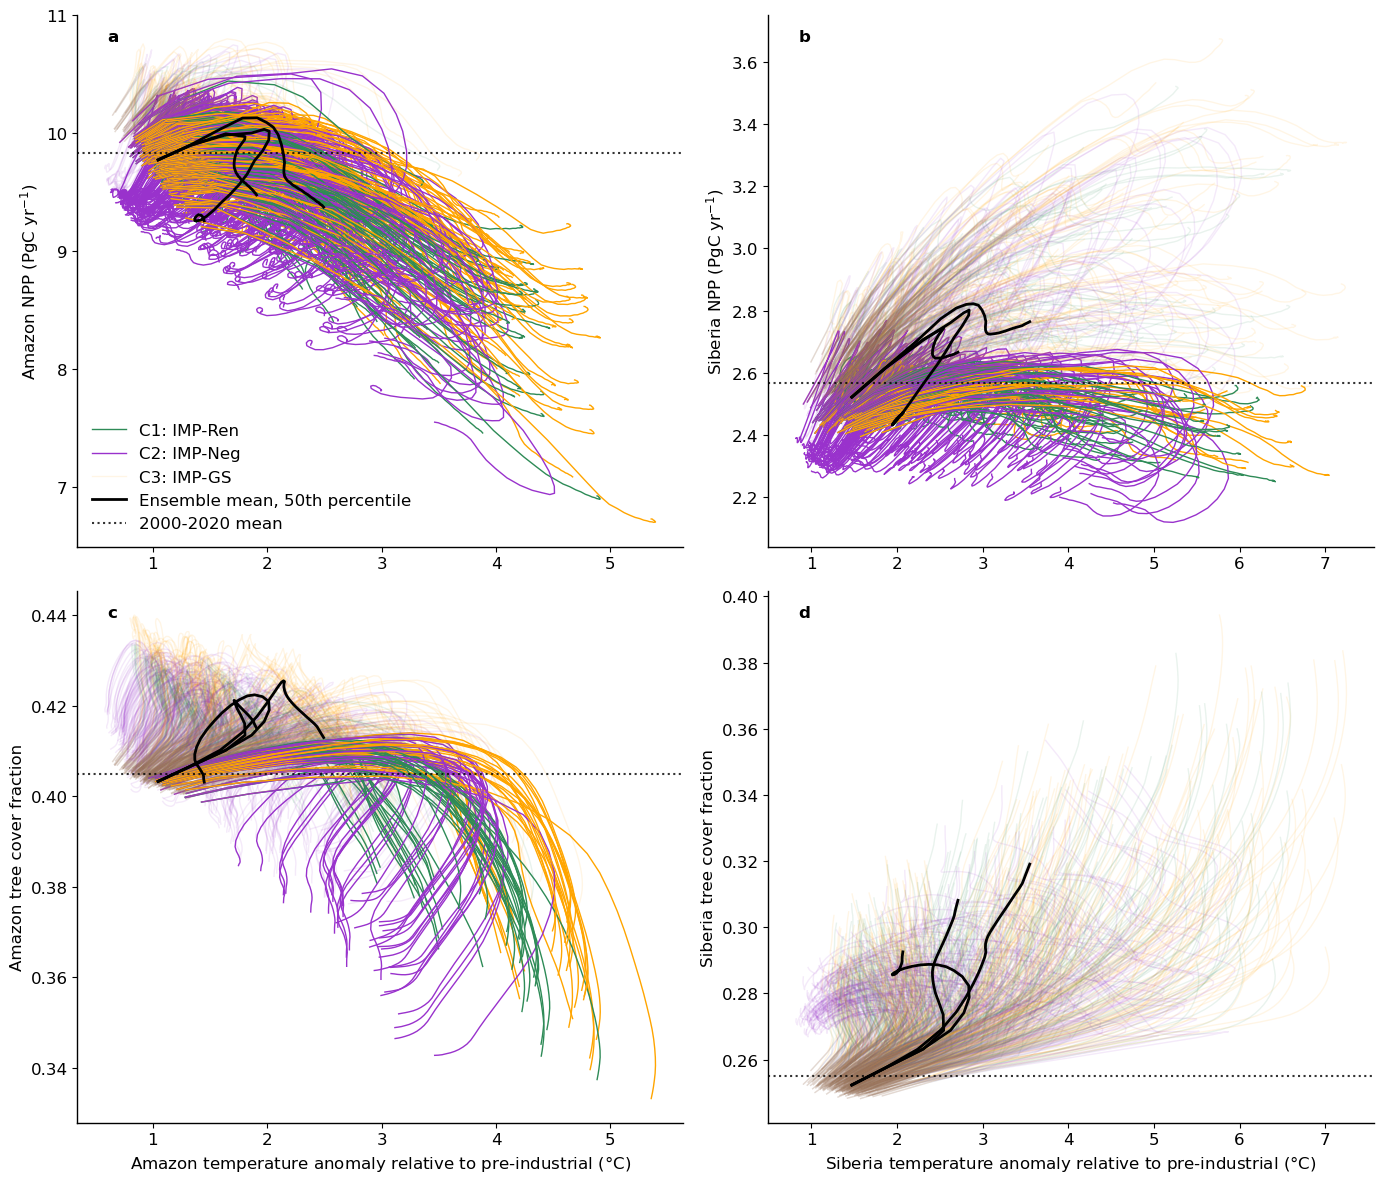

In [18]:
matplotlib.rcParams.update({'font.size': 12})

amazon_conv = amazon_area / 1e12
siberia_conv = siberia_area / 1e12

frac_med_amazon = frac_area_list_amazon_stats[0]
npp_med_amazon = npp_area_list_amazon_stats[0]
frac_med_siberia = frac_area_list_siberia_stats[0]
npp_med_siberia = npp_area_list_siberia_stats[0]

overshoot_peak_ms = 90
linealpha=1
lineps=20
endofline_size=90

fig, ax = plt.subplots(2, 2, figsize=(14, 12))
# plt.suptitle('ECS all percentiles, all ESMs')

last_perc = len(percentiles) - 1
last_cube = len(temp_mean_amazon['C1-IMP-Ren']['0.0']) - 10

for j, p in enumerate(percentiles):
    try:
        for i, _ in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.0']):
            if np.sum(frac_amazon['C1-IMP-Ren'][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                c1_alpha = 1
            else: 
                c1_alpha = 0.1
            if np.sum(frac_amazon['C2-IMP-Neg'][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                c2_alpha = 1
            else:
                c2_alpha = 0.1
            if np.sum(frac_amazon['C3-IMP-GS'][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                c3_alpha = 1
            else:
                c3_alpha = 0.1

            if np.sum(frac_siberia['C1-IMP-Ren'][p][i][25, :5].data, axis=0) < frac_baseline_siberia:
                c1_alpha_s = 1
            else: 
                c1_alpha_s = 0.1
            if np.sum(frac_siberia['C2-IMP-Neg'][p][i][25, :5].data, axis=0) < frac_baseline_siberia:
                c2_alpha_s = 1
            else:
                c2_alpha_s = 0.1
            if np.sum(frac_siberia['C3-IMP-GS'][p][i][25, :5].data, axis=0) < frac_baseline_siberia:
                c3_alpha_s = 1
            else:
                c3_alpha_s = 0.1

            # Tree fraction
            ax[1, 0].plot(temp_mean_amazon['C1-IMP-Ren'][p][i][-decs:].data, np.sum(frac_amazon['C1-IMP-Ren'][p][i][-decs:, :5].data, axis=1), color='seagreen', linewidth=1, alpha=c1_alpha, label="C1: IMP-Ren" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[1, 0].plot(temp_mean_amazon['C2-IMP-Neg'][p][i][-decs:].data, np.sum(frac_amazon['C2-IMP-Neg'][p][i][-decs:, :5].data, axis=1), color='darkorchid', linewidth=1, alpha=c2_alpha, label="C2: IMP-Neg" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[1, 0].plot(temp_mean_amazon['C3-IMP-GS'][p][i][-decs:].data, np.sum(frac_amazon['C3-IMP-GS'][p][i][-decs:, :5].data, axis=1), color='orange', linewidth=1, alpha=c3_alpha, label="C3: IMP-GS" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[1, 1].plot(temp_mean_siberia['C1-IMP-Ren'][p][i][-decs:].data, np.sum(frac_siberia['C1-IMP-Ren'][p][i][-decs:, :5].data, axis=1), color='seagreen', linewidth=1, alpha=c1_alpha_s)
            ax[1, 1].plot(temp_mean_siberia['C2-IMP-Neg'][p][i][-decs:].data, np.sum(frac_siberia['C2-IMP-Neg'][p][i][-decs:, :5].data, axis=1), color='darkorchid', linewidth=1, alpha=c2_alpha_s)
            ax[1, 1].plot(temp_mean_siberia['C3-IMP-GS'][p][i][-decs:].data, np.sum(frac_siberia['C3-IMP-GS'][p][i][-decs:, :5].data, axis=1), color='orange', linewidth=1, alpha=c3_alpha_s)
            
            # NPP
            if npp_amazon['C1-IMP-Ren'][p][i][25].data < npp_baseline_amazon:
                c1_alpha_npp = 1
            else: 
                c1_alpha_npp = 0.1
            if npp_amazon['C2-IMP-Neg'][p][i][25].data < npp_baseline_amazon:
                c2_alpha_npp = 1
            else:
                c2_alpha_npp = 0.1
            if npp_amazon['C3-IMP-GS'][p][i][25].data < npp_baseline_amazon:
                c3_alpha_npp = 1
            else:
                c3_alpha_npp = 0.1

            if npp_siberia['C1-IMP-Ren'][p][i][25].data < npp_baseline_siberia:
                c1_alpha_npp_s = 1
            else: 
                c1_alpha_npp_s = 0.1
            if npp_siberia['C2-IMP-Neg'][p][i][25].data < npp_baseline_siberia:
                c2_alpha_npp_s = 1
            else:
                c2_alpha_npp_s = 0.1
            if npp_siberia['C3-IMP-GS'][p][i][25].data < npp_baseline_siberia:
                c3_alpha_npp_s = 1
            else:
                c3_alpha_npp_s = 0.1

            ax[0, 0].plot(temp_mean_amazon['C1-IMP-Ren'][p][i][-decs:].data , npp_amazon['C1-IMP-Ren'][p][i][-decs:].data*amazon_conv, color='seagreen', linewidth=1, alpha=c1_alpha_npp, label="C1: IMP-Ren" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[0, 0].plot(temp_mean_amazon['C2-IMP-Neg'][p][i][-decs:].data, npp_amazon['C2-IMP-Neg'][p][i][-decs:].data*amazon_conv, color='darkorchid', linewidth=1, alpha=c2_alpha_npp, label="C2: IMP-Neg" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[0, 0].plot(temp_mean_amazon['C3-IMP-GS'][p][i][-decs:].data, npp_amazon['C3-IMP-GS'][p][i][-decs:].data*amazon_conv, color='orange', linewidth=1, alpha=c3_alpha_npp, label="C3: IMP-GS" if (j == last_perc and i == last_cube) else "_nolegend_")
            ax[0, 1].plot(temp_mean_siberia['C1-IMP-Ren'][p][i][-decs:].data , npp_siberia['C1-IMP-Ren'][p][i][-decs:].data*siberia_conv, color='seagreen', linewidth=1, alpha=c1_alpha_npp_s)
            ax[0, 1].plot(temp_mean_siberia['C2-IMP-Neg'][p][i][-decs:].data, npp_siberia['C2-IMP-Neg'][p][i][-decs:].data*siberia_conv, color='darkorchid', linewidth=1, alpha=c2_alpha_npp_s)
            ax[0, 1].plot(temp_mean_siberia['C3-IMP-GS'][p][i][-decs:].data, npp_siberia['C3-IMP-GS'][p][i][-decs:].data*siberia_conv, color='orange', linewidth=1, alpha=c3_alpha_npp_s)
            
    except:
        pass
    
# Plot 50th percentile, ESM medians TREE FRAC
ax[1, 0].plot(np.mean([temp_mean_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.5'])], axis=0), np.mean([np.sum(frac_amazon['C1-IMP-Ren']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_amazon['C1-IMP-Ren']['0.5'])], axis=0), color='black', label='Ensemble mean, 50th percentile', linewidth=2)
ax[1, 0].plot(np.mean([temp_mean_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C2-IMP-Neg']['0.5'])], axis=0), np.mean([np.sum(frac_amazon['C2-IMP-Neg']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_amazon['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 0].plot(np.mean([temp_mean_amazon['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C3-IMP-GS']['0.5'])], axis=0), np.mean([np.sum(frac_amazon['C3-IMP-GS']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_amazon['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 1].plot(np.mean([temp_mean_siberia['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C1-IMP-Ren']['0.5'])], axis=0), np.mean([np.sum(frac_siberia['C1-IMP-Ren']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_siberia['C1-IMP-Ren']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 1].plot(np.mean([temp_mean_siberia['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C2-IMP-Neg']['0.5'])], axis=0), np.mean([np.sum(frac_siberia['C2-IMP-Neg']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_siberia['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[1, 1].plot(np.mean([temp_mean_siberia['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C3-IMP-GS']['0.5'])], axis=0), np.mean([np.sum(frac_siberia['C3-IMP-GS']['0.5'][i][-decs:, :5].data, axis=1) for i, mod in enumerate(frac_siberia['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)

# Plot 50th percentile, ESM medians NPP
ax[0, 0].plot(np.mean([temp_mean_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.5'])], axis=0), np.mean([npp_amazon['C1-IMP-Ren']['0.5'][i][-decs:].data*amazon_conv for i, mod in enumerate(npp_amazon['C1-IMP-Ren']['0.5'])], axis=0), color='black', label='Ensemble mean, 50th percentile', linewidth=2)
ax[0, 0].plot(np.mean([temp_mean_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C2-IMP-Neg']['0.5'])], axis=0), np.mean([npp_amazon['C2-IMP-Neg']['0.5'][i][-decs:].data*amazon_conv for i, mod in enumerate(npp_amazon['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 0].plot(np.mean([temp_mean_amazon['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_amazon['C3-IMP-GS']['0.5'])], axis=0), np.mean([npp_amazon['C3-IMP-GS']['0.5'][i][-decs:].data*amazon_conv for i, mod in enumerate(npp_amazon['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 1].plot(np.mean([temp_mean_siberia['C1-IMP-Ren']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C1-IMP-Ren']['0.5'])], axis=0), np.mean([npp_siberia['C1-IMP-Ren']['0.5'][i][-decs:].data*siberia_conv for i, mod in enumerate(npp_siberia['C1-IMP-Ren']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 1].plot(np.mean([temp_mean_siberia['C2-IMP-Neg']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C2-IMP-Neg']['0.5'])], axis=0), np.mean([npp_siberia['C2-IMP-Neg']['0.5'][i][-decs:].data*siberia_conv for i, mod in enumerate(npp_siberia['C2-IMP-Neg']['0.5'])], axis=0), color='black', linewidth=2)
ax[0, 1].plot(np.mean([temp_mean_siberia['C3-IMP-GS']['0.5'][i][-decs:].data for i, mod in enumerate(temp_mean_siberia['C3-IMP-GS']['0.5'])], axis=0), np.mean([npp_siberia['C3-IMP-GS']['0.5'][i][-decs:].data*siberia_conv for i, mod in enumerate(npp_siberia['C3-IMP-GS']['0.5'])], axis=0), color='black', linewidth=2)

# Axes labels
ax[1, 0].set_ylabel('Amazon tree cover fraction')
ax[1, 0].set_xlabel('Amazon temperature anomaly relative to pre-industrial ($\degree$C)')
ax[1, 1].set_ylabel('Siberia tree cover fraction')

ax[0, 0].set_ylabel('Amazon NPP (PgC yr$^{-1}$)')
ax[1, 1].set_xlabel('Siberia temperature anomaly relative to pre-industrial ($\degree$C)')
ax[0, 1].set_ylabel('Siberia NPP (PgC yr$^{-1}$)')

# Tree frac
# ax[0, 0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax[0, 0].yaxis.set_major_locator(MultipleLocator(0.004))
# ax[0, 0].yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))
# ax[1, 0].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax[1, 0].yaxis.set_major_locator(MultipleLocator(0.01))
# ax[1, 0].yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

# NPP
# ax[0, 1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax[0, 1].yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))
# ax[1, 1].yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
# ax[1, 1].yaxis.set_minor_formatter(FormatStrFormatter("%.3f"))

# 2000-2020 mean hlines
ax[1, 0].axhline(frac_baseline_amazon, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)
ax[1, 1].axhline(frac_baseline_siberia, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)
ax[0, 0].axhline(npp_baseline_amazon*amazon_conv, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)
ax[0, 1].axhline(npp_baseline_siberia*siberia_conv, color='black', linestyle='dotted', label='2000-2020 mean', alpha=0.8)

# Region annotations
ax[0, 0].text(0.05, 0.95, 'a', transform=ax[0, 0].transAxes, color='black', weight='bold')
ax[0, 1].text(0.05, 0.95, 'b', transform=ax[0, 1].transAxes, color='black', weight='bold')
ax[1, 0].text(0.05, 0.95, 'c', transform=ax[1, 0].transAxes, color='black', weight='bold')
ax[1, 1].text(0.05, 0.95, 'd', transform=ax[1, 1].transAxes, color='black', weight='bold')

ax[0, 0].legend(loc='lower left', frameon=False)

ax[0, 0].spines[['right', 'top']].set_visible(False)
ax[0, 1].spines[['right', 'top']].set_visible(False)
ax[1, 0].spines[['right', 'top']].set_visible(False)
ax[1, 1].spines[['right', 'top']].set_visible(False)

for axis in ['top','bottom','left','right']:
    ax[0, 0].spines[axis].set_linewidth(1)
    ax[0, 1].spines[axis].set_linewidth(1)
    ax[1, 0].spines[axis].set_linewidth(1)
    ax[1, 1].spines[axis].set_linewidth(1)

plt.tight_layout()
plt.savefig('../paper_plots/fig3_regional_temps.png', dpi=500)
plt.show()
plt.close()

Risk probability density function

In [22]:
frac_ends_amazon = []
frac_ends_siberia = []
for j, p in enumerate(percentiles):
    for i, _ in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.0']):
        for scen in scenarios:
            frac_ends_amazon.append(np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0))
            frac_ends_siberia.append(np.sum(frac_siberia[scen][p][i][-1, :5].data, axis=0))

In [23]:
npp_ends_amazon = []
npp_ends_siberia = []
for j, p in enumerate(percentiles):
    for i, _ in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.0']):
        for scen in scenarios:
            npp_ends_amazon.append(float(npp_amazon[scen][p][i][-1].data))
            npp_ends_siberia.append(float(npp_siberia[scen][p][i][-1].data))

In [39]:
frac_ends_amazon_c1 = []
frac_ends_amazon_c2 = []
frac_ends_amazon_c3 = []
frac_ends_amazon_ssp = []

frac_ends_siberia_c1 = []
frac_ends_siberia_c2 = []
frac_ends_siberia_c3 = []
frac_ends_siberia_ssp = []

for j, p in enumerate(percentiles):
    for i, _ in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.0']):
        frac_ends_amazon_c1.append(np.sum(frac_amazon['C1-IMP-Ren'][p][i][-1, :5].data, axis=0))
        frac_ends_siberia_c1.append(np.sum(frac_siberia['C1-IMP-Ren'][p][i][-1, :5].data, axis=0))
        frac_ends_amazon_c2.append(np.sum(frac_amazon['C2-IMP-Neg'][p][i][-1, :5].data, axis=0))
        frac_ends_siberia_c2.append(np.sum(frac_siberia['C2-IMP-Neg'][p][i][-1, :5].data, axis=0))
        frac_ends_amazon_c3.append(np.sum(frac_amazon['C3-IMP-GS'][p][i][-1, :5].data, axis=0))
        frac_ends_siberia_c3.append(np.sum(frac_siberia['C3-IMP-GS'][p][i][-1, :5].data, axis=0))
        frac_ends_amazon_ssp.append(np.sum(frac_amazon['ssprcmip_ssp534_over'][p][i][-1, :5].data, axis=0))
        frac_ends_siberia_ssp.append(np.sum(frac_siberia['ssprcmip_ssp534_over'][p][i][-1, :5].data, axis=0))
        
npp_ends_amazon_c1 = []
npp_ends_amazon_c2 = []
npp_ends_amazon_c3 = []
npp_ends_amazon_ssp = []

npp_ends_siberia_c1 = []
npp_ends_siberia_c2 = []
npp_ends_siberia_c3 = []
npp_ends_siberia_ssp = []

for j, p in enumerate(percentiles):
    for i, _ in enumerate(temp_mean_amazon['C1-IMP-Ren']['0.0']):
        npp_ends_amazon_c1.append(float(npp_amazon['C1-IMP-Ren'][p][i][-1].data))
        npp_ends_siberia_c1.append(float(npp_siberia['C1-IMP-Ren'][p][i][-1].data))
        npp_ends_amazon_c2.append(float(npp_amazon['C2-IMP-Neg'][p][i][-1].data))
        npp_ends_siberia_c2.append(float(npp_siberia['C2-IMP-Neg'][p][i][-1].data))
        npp_ends_amazon_c3.append(float(npp_amazon['C3-IMP-GS'][p][i][-1].data))
        npp_ends_siberia_c3.append(float(npp_siberia['C3-IMP-GS'][p][i][-1].data))
        npp_ends_amazon_ssp.append(float(npp_amazon['ssprcmip_ssp534_over'][p][i][-1].data))
        npp_ends_siberia_ssp.append(float(npp_siberia['ssprcmip_ssp534_over'][p][i][-1].data))

In [43]:
def calculate_probability(data: np.ndarray, thresh_val: float) -> float:
    # use cumulative distribution to calculate low threshold
    data_x, data_y = sns.kdeplot(data, cumulative=True).lines[0].get_data()
    plt.close()

    def find_nearest(array, value):
        array = np.asarray(array)
        idx = (np.abs(array - value)).argmin()
        return array[idx]

    min_arg =  np.argwhere(data_x == find_nearest(data_x, thresh_val))
    prob = data_y[min_arg]

    return prob[0][0]

# prob_amazon = calculate_probability(frac_ends_amazon, frac_baseline_amazon)
# prob_siberia = calculate_probability(frac_ends_siberia, frac_baseline_siberia)
# prob_amazon_c1 = calculate_probability(frac_ends_amazon_c1, frac_baseline_amazon)
# prob_siberia_c1 = calculate_probability(frac_ends_siberia_c1, frac_baseline_siberia)
# prob_amazon_c2 = calculate_probability(frac_ends_amazon_c2, frac_baseline_amazon)
# prob_siberia_c2 = calculate_probability(frac_ends_siberia_c2, frac_baseline_siberia)
# prob_amazon_c3 = calculate_probability(frac_ends_amazon_c3, frac_baseline_amazon)
# prob_siberia_c3 = calculate_probability(frac_ends_siberia_c3, frac_baseline_siberia)
# prob_amazon_ssp = calculate_probability(frac_ends_amazon_ssp, frac_baseline_amazon)
# prob_siberia_ssp = calculate_probability(frac_ends_siberia_ssp, frac_baseline_siberia)

prob_amazon_npp = calculate_probability(npp_ends_amazon, npp_baseline_amazon)
prob_siberia_npp = calculate_probability(npp_ends_siberia, npp_baseline_siberia)
prob_amazon_c1_npp = calculate_probability(npp_ends_amazon_c1, npp_baseline_amazon)
prob_siberia_c1_npp = calculate_probability(npp_ends_siberia_c1, npp_baseline_siberia)
prob_amazon_c2_npp = calculate_probability(npp_ends_amazon_c2, npp_baseline_amazon)
prob_siberia_c2_npp = calculate_probability(npp_ends_siberia_c2, npp_baseline_siberia)
prob_amazon_c3_npp = calculate_probability(npp_ends_amazon_c3, npp_baseline_amazon)
prob_siberia_c3_npp = calculate_probability(npp_ends_siberia_c3, npp_baseline_siberia)
prob_amazon_ssp_npp = calculate_probability(npp_ends_amazon_ssp, npp_baseline_amazon)
prob_siberia_ssp_npp = calculate_probability(npp_ends_siberia_ssp, npp_baseline_siberia)


# print(f'Probability of lower than 2000-2020 baseline Amazon tree frac: {prob_amazon*100:.2f}%')
# print(f'Probability of lower than 2000-2020 baseline Siberia tree frac: {prob_siberia*100:.2f}%')

print(f'Probability of lower than 2000-2020 baseline Amazon NPP: {prob_amazon_npp*100:.2f}%')
print(f'Probability of lower than 2000-2020 baseline Siberia NPP: {prob_siberia_npp*100:.2f}%')

Probability of lower than 2000-2020 baseline Amazon NPP: 58.46%
Probability of lower than 2000-2020 baseline Siberia NPP: 28.07%


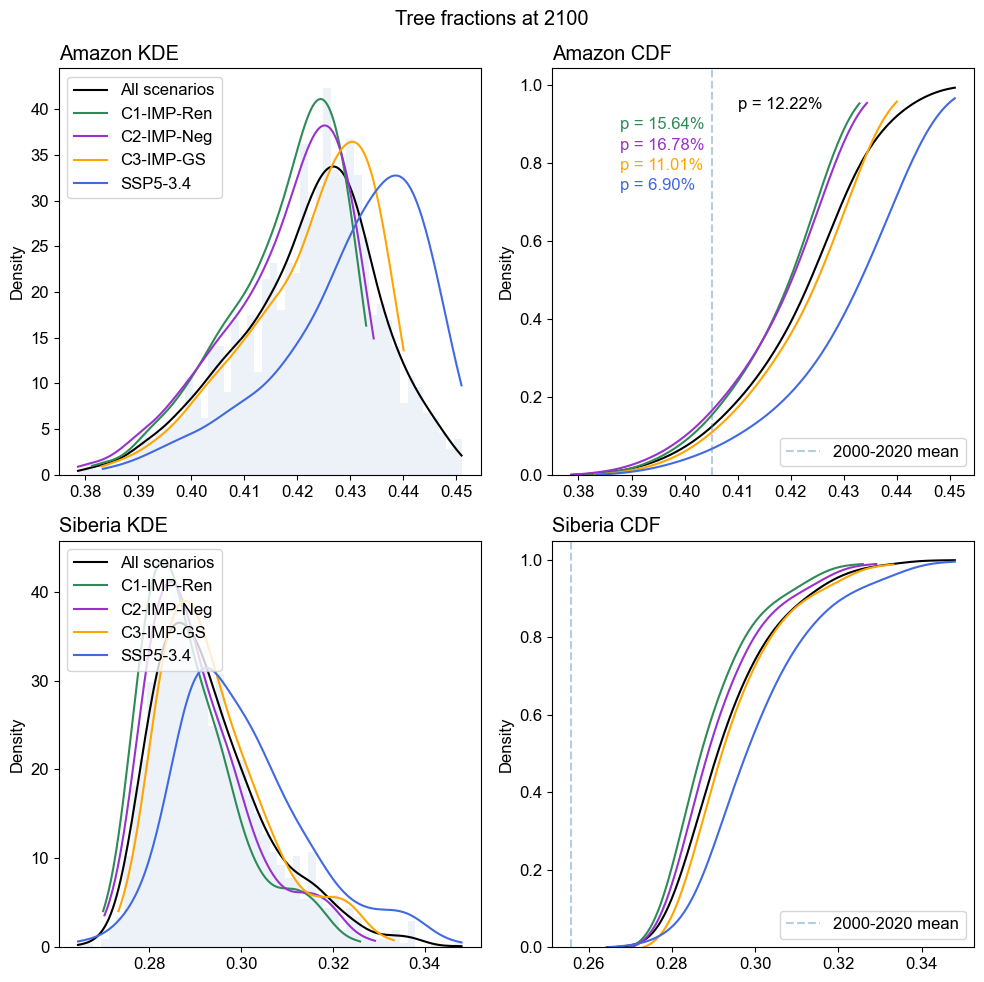

In [29]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.suptitle('Tree fractions at 2100')

# Amazon distributions
ax[0, 0].hist(frac_ends_amazon, density=True, bins=50, histtype='stepfilled', color='steelblue', alpha=0.1)
sns.kdeplot(frac_ends_amazon, cut=0, ax=ax[0, 0], color='black', label='All scenarios')
sns.kdeplot(frac_ends_amazon_c1, cut=0, ax=ax[0, 0], color='seagreen', label='C1-IMP-Ren')
sns.kdeplot(frac_ends_amazon_c2, cut=0, ax=ax[0, 0], color='darkorchid', label='C2-IMP-Neg')
sns.kdeplot(frac_ends_amazon_c3, cut=0, ax=ax[0, 0], color='orange', label='C3-IMP-GS')
sns.kdeplot(frac_ends_amazon_ssp, cut=0, ax=ax[0, 0], color='royalblue', label='SSP5-3.4')
ax[0, 0].set_title('Amazon PDF', loc='left')
ax[0, 0].legend(loc='upper left')

sns.kdeplot(frac_ends_amazon, cut=0, cumulative=True, ax=ax[0, 1], color='black')
sns.kdeplot(frac_ends_amazon_c1, cut=0, cumulative=True, ax=ax[0, 1], color='seagreen')
sns.kdeplot(frac_ends_amazon_c2, cut=0, cumulative=True, ax=ax[0, 1], color='darkorchid')
sns.kdeplot(frac_ends_amazon_c3, cut=0, cumulative=True, ax=ax[0, 1], color='orange')
sns.kdeplot(frac_ends_amazon_ssp, cut=0, cumulative=True, ax=ax[0, 1], color='royalblue')
ax[0, 1].axvline(frac_baseline_amazon, color='steelblue', alpha=0.4, linestyle='dashed', label='2000-2020 mean')
ax[0, 1].set_title('Amazon CDF', loc='left')
ax[0, 1].legend(loc='lower right')
ax[0, 1].text(0.44, 0.9, f'p = {prob_amazon*100:.2f}%', transform=ax[0, 1].transAxes, color='black')
ax[0, 1].text(0.16, 0.85, f'p = {prob_amazon_c1*100:.2f}%', transform=ax[0, 1].transAxes, color='seagreen')
ax[0, 1].text(0.16, 0.8, f'p = {prob_amazon_c2*100:.2f}%', transform=ax[0, 1].transAxes, color='darkorchid')
ax[0, 1].text(0.16, 0.75, f'p = {prob_amazon_c3*100:.2f}%', transform=ax[0, 1].transAxes, color='orange')
ax[0, 1].text(0.16, 0.70, f'p = {prob_amazon_ssp*100:.2f}%', transform=ax[0, 1].transAxes, color='royalblue')

# Siberia distributions
ax[1, 0].hist(frac_ends_siberia, density=True, bins=50, histtype='stepfilled', color='steelblue', alpha=0.1)
sns.kdeplot(frac_ends_siberia, cut=0, ax=ax[1, 0], color='black', label='All scenarios')
sns.kdeplot(frac_ends_siberia_c1, cut=0, ax=ax[1, 0], color='seagreen', label='C1-IMP-Ren')
sns.kdeplot(frac_ends_siberia_c2, cut=0, ax=ax[1, 0], color='darkorchid', label='C2-IMP-Neg')
sns.kdeplot(frac_ends_siberia_c3, cut=0, ax=ax[1, 0], color='orange', label='C3-IMP-GS')
sns.kdeplot(frac_ends_siberia_ssp, cut=0, ax=ax[1, 0], color='royalblue', label='SSP5-3.4')
ax[1, 0].set_title('Siberia PDF', loc='left')
ax[1, 0].legend(loc='upper left')

sns.kdeplot(frac_ends_siberia, cut=0, cumulative=True, ax=ax[1, 1], color='black')
sns.kdeplot(frac_ends_siberia_c1, cut=0, cumulative=True, ax=ax[1, 1], color='seagreen')
sns.kdeplot(frac_ends_siberia_c2, cut=0, cumulative=True, ax=ax[1, 1], color='darkorchid' )
sns.kdeplot(frac_ends_siberia_c3, cut=0, cumulative=True, ax=ax[1, 1], color='orange')
sns.kdeplot(frac_ends_siberia_ssp, cut=0, cumulative=True, ax=ax[1, 1], color='royalblue')
ax[1, 1].axvline(frac_baseline_siberia, color='steelblue', alpha=0.4, linestyle='dashed', label='2000-2020 mean')
ax[1, 1].set_title('Siberia CDF', loc='left')
ax[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('../paper_plots/amazon_siberia_treefrac_kde_cdf_ssp', dpi=500)
plt.show()
plt.close()

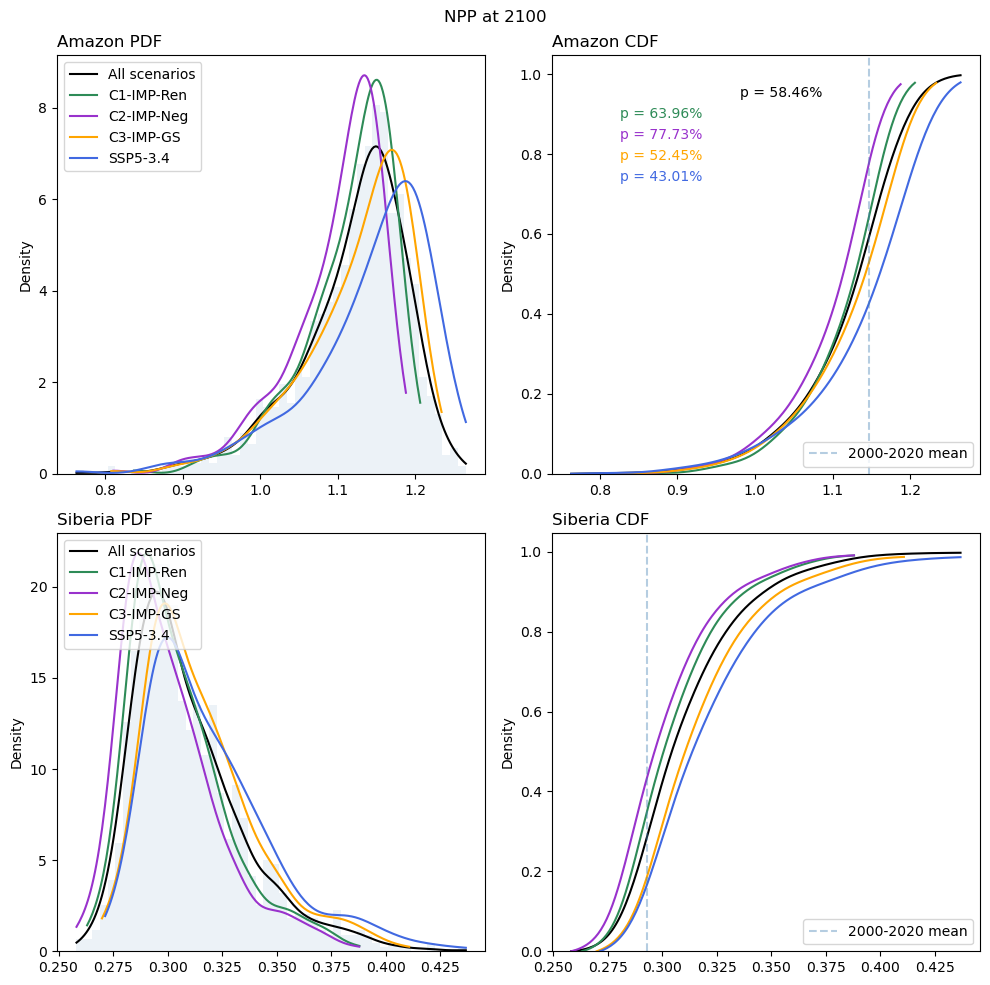

In [44]:
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
plt.suptitle('NPP at 2100')

# Amazon distributions
ax[0, 0].hist(npp_ends_amazon, density=True, bins=50, histtype='stepfilled', color='steelblue', alpha=0.1)
sns.kdeplot(npp_ends_amazon, cut=0, ax=ax[0, 0], color='black', label='All scenarios')
sns.kdeplot(npp_ends_amazon_c1, cut=0, ax=ax[0, 0], color='seagreen', label='C1-IMP-Ren')
sns.kdeplot(npp_ends_amazon_c2, cut=0, ax=ax[0, 0], color='darkorchid', label='C2-IMP-Neg')
sns.kdeplot(npp_ends_amazon_c3, cut=0, ax=ax[0, 0], color='orange', label='C3-IMP-GS')
sns.kdeplot(npp_ends_amazon_ssp, cut=0, ax=ax[0, 0], color='royalblue', label='SSP5-3.4')
ax[0, 0].set_title('Amazon PDF', loc='left')
ax[0, 0].legend(loc='upper left')

sns.kdeplot(npp_ends_amazon, cut=0, cumulative=True, ax=ax[0, 1], color='black')
sns.kdeplot(npp_ends_amazon_c1, cut=0, cumulative=True, ax=ax[0, 1], color='seagreen')
sns.kdeplot(npp_ends_amazon_c2, cut=0, cumulative=True, ax=ax[0, 1], color='darkorchid')
sns.kdeplot(npp_ends_amazon_c3, cut=0, cumulative=True, ax=ax[0, 1], color='orange')
sns.kdeplot(npp_ends_amazon_ssp, cut=0, cumulative=True, ax=ax[0, 1], color='royalblue')
ax[0, 1].axvline(npp_baseline_amazon, color='steelblue', alpha=0.4, linestyle='dashed', label='2000-2020 mean')
ax[0, 1].set_title('Amazon CDF', loc='left')
ax[0, 1].legend(loc='lower right')
ax[0, 1].text(0.44, 0.9, f'p = {prob_amazon_npp*100:.2f}%', transform=ax[0, 1].transAxes, color='black')
ax[0, 1].text(0.16, 0.85, f'p = {prob_amazon_c1_npp*100:.2f}%', transform=ax[0, 1].transAxes, color='seagreen')
ax[0, 1].text(0.16, 0.8, f'p = {prob_amazon_c2_npp*100:.2f}%', transform=ax[0, 1].transAxes, color='darkorchid')
ax[0, 1].text(0.16, 0.75, f'p = {prob_amazon_c3_npp*100:.2f}%', transform=ax[0, 1].transAxes, color='orange')
ax[0, 1].text(0.16, 0.70, f'p = {prob_amazon_ssp_npp*100:.2f}%', transform=ax[0, 1].transAxes, color='royalblue')

# Siberia distributions
ax[1, 0].hist(npp_ends_siberia, density=True, bins=50, histtype='stepfilled', color='steelblue', alpha=0.1)
sns.kdeplot(npp_ends_siberia, cut=0, ax=ax[1, 0], color='black', label='All scenarios')
sns.kdeplot(npp_ends_siberia_c1, cut=0, ax=ax[1, 0], color='seagreen', label='C1-IMP-Ren')
sns.kdeplot(npp_ends_siberia_c2, cut=0, ax=ax[1, 0], color='darkorchid', label='C2-IMP-Neg')
sns.kdeplot(npp_ends_siberia_c3, cut=0, ax=ax[1, 0], color='orange', label='C3-IMP-GS')
sns.kdeplot(npp_ends_siberia_ssp, cut=0, ax=ax[1, 0], color='royalblue', label='SSP5-3.4')
ax[1, 0].set_title('Siberia PDF', loc='left')
ax[1, 0].legend(loc='upper left')

sns.kdeplot(npp_ends_siberia, cut=0, cumulative=True, ax=ax[1, 1], color='black')
sns.kdeplot(npp_ends_siberia_c1, cut=0, cumulative=True, ax=ax[1, 1], color='seagreen')
sns.kdeplot(npp_ends_siberia_c2, cut=0, cumulative=True, ax=ax[1, 1], color='darkorchid' )
sns.kdeplot(npp_ends_siberia_c3, cut=0, cumulative=True, ax=ax[1, 1], color='orange')
sns.kdeplot(npp_ends_siberia_ssp, cut=0, cumulative=True, ax=ax[1, 1], color='royalblue')
ax[1, 1].axvline(npp_baseline_siberia, color='steelblue', alpha=0.4, linestyle='dashed', label='2000-2020 mean')
ax[1, 1].set_title('Siberia CDF', loc='left')
ax[1, 1].legend(loc='lower right')

plt.tight_layout()
plt.savefig('../paper_plots/amazon_siberia_npp_kde_cdf_ssp', dpi=500)
plt.show()
plt.close()

In [29]:
### 2100 Models ###

c1_frac_models = []
c2_frac_models = []
c3_frac_models = []

c1_temp_frac_models = []
c2_temp_frac_models = []
c3_temp_frac_models = []

c1_precip_frac_models = []
c2_precip_frac_models = []
c3_precip_frac_models = []

c1_gtemp_models = []
c2_gtemp_models = []
c3_gtemp_models = []

### 2300 models ###

c1_frac_models_l = []
c2_frac_models_l = []
c3_frac_models_l = []

c1_temp_frac_models_l = []
c2_temp_frac_models_l = []
c3_temp_frac_models_l = []

c1_precip_frac_models_l = []
c2_precip_frac_models_l = []
c3_precip_frac_models_l = []

c1_gtemp_models_l = []
c2_gtemp_models_l = []
c3_gtemp_models_l = []

### Not models ###

not_temps = []
not_gtemps = []
not_precip = []

c1_frac_not_2100 = []
c2_frac_not_2100 = []
c3_frac_not_2100 = []

c1_frac_not_2300 = []
c2_frac_not_2300 = []
c3_frac_not_2300 = []

dec = 25

for scen in scenarios:
    for j, p in enumerate(percentiles):
        for i, _ in enumerate(temp_mean_amazon[scen][p]):
            # Select fracs that come in below present day threshold in 2100
            if np.sum(frac_amazon[scen][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_models.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    c1_temp_frac_models.append(temp_amazon[scen][p][i][dec].data)
                    c1_precip_frac_models.append(precip_amazon[scen][p][i][dec].data)
                    c1_gtemp_models.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C2-IMP-Neg':       
                    c2_frac_models.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    c2_temp_frac_models.append(temp_amazon[scen][p][i][dec].data)
                    c2_precip_frac_models.append(precip_amazon[scen][p][i][dec].data)
                    c2_gtemp_models.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_models.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    c3_temp_frac_models.append(temp_amazon[scen][p][i][dec].data)
                    c3_precip_frac_models.append(precip_amazon[scen][p][i][dec].data)
                    c3_gtemp_models.append(gtemp_dict[scen][p][dec])
                    
            # Select models that fall below present-day threshold in 2300
            if np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_models_l.append(np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0))
                    c1_temp_frac_models_l.append(temp_amazon[scen][p][i][dec].data)
                    c1_precip_frac_models_l.append(precip_amazon[scen][p][i][dec].data)
                    c1_gtemp_models_l.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C2-IMP-Neg':
                    c2_frac_models_l.append(np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0))
                    c2_temp_frac_models_l.append(temp_amazon[scen][p][i][dec].data)
                    c2_precip_frac_models_l.append(precip_amazon[scen][p][i][dec].data)
                    c2_gtemp_models_l.append(gtemp_dict[scen][p][dec])
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_models_l.append(np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0))
                    c3_temp_frac_models_l.append(temp_amazon[scen][p][i][dec].data)
                    c3_precip_frac_models_l.append(precip_amazon[scen][p][i][dec].data)
                    c3_gtemp_models_l.append(gtemp_dict[scen][p][dec])
                    
            # Select all models that don't fall below present-day threshold at 2100
            if not np.sum(frac_amazon[scen][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                not_temps.append(temp_amazon[scen][p][i][dec].data)
                not_precip.append(precip_amazon[scen][p][i][dec].data)
                not_gtemps.append(gtemp_dict[scen][p][dec])
                
            # Select specific scenario models that don't fall below present-day threshold at 2100
            if not np.sum(frac_amazon[scen][p][i][25, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_not_2100.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))

                if scen == 'C2-IMP-Neg':
                    c2_frac_not_2100.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_not_2100.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    
            # Select models that don't fall below threshold at 2300
            if not np.sum(frac_amazon[scen][p][i][-1, :5].data, axis=0) < frac_baseline_amazon:
                if scen == 'C1-IMP-Ren':
                    c1_frac_not_2300.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))

                if scen == 'C2-IMP-Neg':
                    c2_frac_not_2300.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))
                    
                if scen == 'C3-IMP-GS':
                    c3_frac_not_2300.append(np.sum(frac_amazon[scen][p][i][dec, :5].data, axis=0))

In [30]:
# Combine scenarios for group statistics
temp_models = c1_temp_frac_models + c2_temp_frac_models + c3_temp_frac_models
gtemp_models = c1_gtemp_models + c2_gtemp_models + c3_gtemp_models
temp_models_l = c1_temp_frac_models_l + c2_temp_frac_models_l + c3_temp_frac_models_l
gtemp_models_l = c1_gtemp_models_l + c2_gtemp_models_l + c3_gtemp_models_l
precip_models = c1_precip_frac_models + c2_precip_frac_models + c3_precip_frac_models
precip_models_l = c1_precip_frac_models_l + c2_precip_frac_models_l + c3_precip_frac_models_l

# Calculate mean temperature of all models that don't pass threshold by 2100
mean_temp = np.mean(not_temps + temp_models)
mean_gtemp = np.mean(not_gtemps)
mean_precip = np.mean(not_precip + precip_models)

twosig_temp = np.percentile(temp_models, 5)
twosig_gtemp = np.percentile(gtemp_models, 5)
twosig_precip = np.percentile(precip_models, 95)

twosig_temp_l = np.percentile(temp_models_l, 5)
twosig_gtemp_l = np.percentile(gtemp_models_l, 5)
twosig_precip_l =  np.percentile(precip_models_l, 95)

In [31]:
models_path = '/scratch/hadea/imogen_post/imogen6/u-bd604_gmtchange_es_2300/'
strs = glob.glob(models_path + '*.nc')
models = []
for el in strs:
    if el.split('_')[4] not in models:
        models.append(el.split('_')[4])
models = sorted([model[5:] for model in models])

In [32]:
amazon_temps = []
amazon_precips = []
global_temps = []
temp_dict = {}
precip_dict = {}
global_dict = {}

for model in models:
    temp_dict[model] = []
    precip_dict[model] = []
    global_dict[model] = []

for scen in scenarios:
    for p in percentiles:
        for i, m in enumerate(models):
            # amazon_temps.append(np.mean([x.data for x in temp_amazon[scen][p]], axis=0))
            # amazon_precips.append(np.mean([x.data for x in precip_amazon[scen][p]], axis=0))
            # global_temps.append(gtemp_dict[scen][p])
            temp_dict[m].append(temp_amazon[scen][p][i].data)
            precip_dict[m].append(precip_amazon[scen][p][i].data)
            global_dict[m].append(gtemp_dict[scen][p])
            
            amazon_temps.append(temp_amazon[scen][p][i].data)
            amazon_precips.append(precip_amazon[scen][p][i].data)
            global_temps.append(gtemp_dict[scen][p])
        
for model in models:
    temp_dict[model] = np.concatenate(np.array(temp_dict[model]))
    precip_dict[model] = np.concatenate(np.array(precip_dict[model]))
    global_dict[model] = np.concatenate(np.array(global_dict[model]))
        
amazon_temps = np.concatenate(np.array(amazon_temps))
amazon_precips = np.concatenate(np.array(amazon_precips))
global_temps = np.concatenate(np.array(global_temps))

In [33]:
import matplotlib.colors as mcolors


names = sorted(mcolors.XKCD_COLORS, key=lambda c: tuple(mcolors.rgb_to_hsv(mcolors.to_rgb(c))))
col_inds = np.arange(0, len(names), int(len(names) / 34))

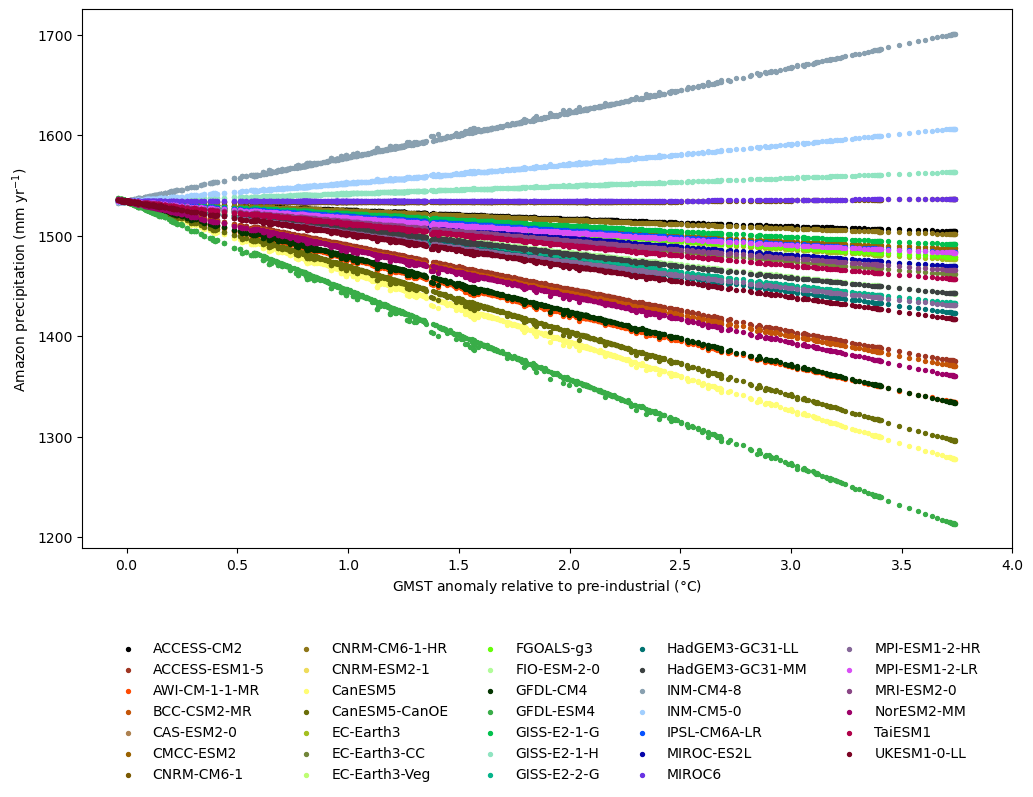

In [34]:
m, c, r, p, se = scipy.stats.linregress(global_temps, amazon_precips)
y = m*global_temps + c

fig = plt.figure(figsize=(12, 7))

ax = fig.add_subplot(111)
for i, model in enumerate(models):
    ax.scatter(global_dict[model], precip_dict[model]*60*60*24*360, color=names[col_inds[i]], marker='o', s=8, alpha=1, label=f'{model}')
    
# ax.plot(global_temps, y*60*60*24*360, color='orange')
ax.set_ylabel('Amazon precipitation (mm yr$^{-1}$)')
ax.set_xlabel('GMST anomaly relative to pre-industrial ($\degree$C)')
ax.set_xlim([-0.2, 4.0])
ax.legend(loc='upper center', frameon=False, bbox_to_anchor=(0.5, -0.15),
          fancybox=True, ncol=5)

In [35]:
m, c, r, p, se = scipy.stats.linregress(global_temps, amazon_temps)
y = m*global_temps

print(f'Global temp 1.5, Amazon temp = {1.5*m}')
print(f'Global temp 2.0, Amazon temp = {2.0*m}')

lower_temp = 1.5*m
upper_temp = 2.0*m

Global temp 1.5, Amazon temp = 1.7933619141480521
Global temp 2.0, Amazon temp = 2.3911492188640695


In [36]:
y_err = ((y - amazon_temps)**2 + (global_temps - (global_temps))**2)**0.5

m_upp, c, r, p, se = scipy.stats.linregress(global_temps, y+y_err)
upper_error = m_upp*global_temps

m_low, c, r, p, se = scipy.stats.linregress(global_temps, y-y_err)
lower_error = m_low*global_temps

In [37]:
lb = twosig_temp / m_upp
ub = twosig_temp / m_low

lb2 = twosig_temp_l / m_upp
ub2 = twosig_temp_l / m_low

print(f'Lower bound at higher temp: {lb}')
print(f'Upper bound at higher temp: {ub}')
print(f'Lower bound at lower temp: {lb2}')
print(f'Upper bound at lower temp: {ub2}')

Lower bound at higher temp: 1.9951782979376842
Upper bound at higher temp: 2.3052103341358534
Lower bound at lower temp: 1.274160049766878
Upper bound at lower temp: 1.4721525976408745


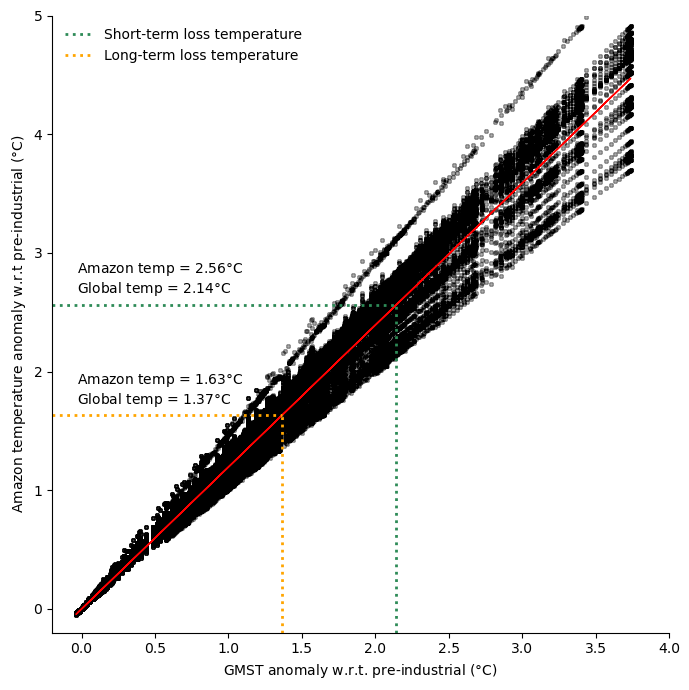

In [38]:
fig = plt.figure(figsize=(7, 7))

ax = fig.add_subplot(111)

for scen in scenarios:
    for p in percentiles:
        ax.scatter(global_temps, amazon_temps, color='k', marker='o', s=8, alpha=0.01)
ax.plot(global_temps, y, color='red', lw=1)
# ax.plot(global_temps, upper_error, color='red', ls=':', lw=1) 
# ax.plot(global_temps, lower_error, color='red', ls=':', lw=1) 

# Plot temperature correspondence
ax.plot([twosig_temp / m, twosig_temp / m], [-0.2, twosig_temp], color='seagreen', linestyle=':', lw=2, label='Short-term loss temperature')
ax.plot([-0.2, twosig_temp / m], [twosig_temp, twosig_temp], color='seagreen', linestyle=':', lw=2)

ax.plot([twosig_temp_l / m, twosig_temp_l / m], [-0.2, twosig_temp_l], color='orange', linestyle=':', lw=2, label='Long-term loss temperature')
ax.plot([-0.2, twosig_temp_l / m], [twosig_temp_l, twosig_temp_l], color='orange', linestyle=':', lw=2)

ax.text(0.04, 0.55, f'Amazon temp = {(twosig_temp):.2f}$\degree$C\nGlobal temp = {(twosig_temp / m):.2f}$\degree$C', transform=ax.transAxes, color='black', ha="left")
ax.text(0.04, 0.37, f'Amazon temp = {(twosig_temp_l):.2f}$\degree$C\nGlobal temp = {(twosig_temp_l / m):.2f}$\degree$C', transform=ax.transAxes, color='black', ha="left")

ax.set_xlabel('GMST anomaly w.r.t. pre-industrial ($\degree$C)')
ax.set_ylabel('Amazon temperature anomaly w.r.t pre-industrial ($\degree$C)')
ax.set_xlim([-0.2, 4])
ax.set_ylim([-0.2, 5])

plt.legend(loc='upper left', frameon=False)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('../paper_plots/temperature_correspondence.png', dpi=300)

In [39]:
print(f'Total number of models: {len(not_temps) + len(temp_models)}')

Total number of models: 918


In [40]:
frac_models = c1_frac_models + c2_frac_models + c3_frac_models
frac_models_l = c1_frac_models_l + c2_frac_models_l + c3_frac_models_l

Probability of loss if in danger zone

In [41]:
twosig_temp

2.5573563246120385

In [42]:
# Calculate probability of tree loss, in 2100 danger zone
models_not_exceed = [temp for i, temp in enumerate(not_temps) if ((temp >= twosig_temp) and (not_precip[i] <= twosig_precip))]
models_exceed = [temp for i, temp in enumerate(temp_models) if ((temp >= twosig_temp) and (precip_models[i] <= twosig_precip))]
exceedence_2100_prob_danger = (len(models_exceed) / (len(models_exceed) + len(models_not_exceed))) * 100
print(f'Probability of exceeding in 2100, if in 2100 danger zone: {exceedence_2100_prob_danger}')

models_not_exceed_l = [temp for i, temp in enumerate(not_temps) if ((temp >= twosig_temp_l) and (not_precip[i] <= twosig_precip_l))]
models_exceed_l = [temp for i, temp in enumerate(temp_models_l) if ((temp >= twosig_temp_l) and (precip_models_l[i] <= twosig_precip_l))]
exceedence_2100_prob_danger_l = (len(models_exceed_l) / (len(models_exceed_l) + len(models_not_exceed_l))) * 100
print(f'Probability of exceeding in 2300, if in 2100 danger zone: {exceedence_2100_prob_danger_l}')

Probability of exceeding in 2100, if in 2100 danger zone: 51.33689839572193
Probability of exceeding in 2300, if in 2100 danger zone: 48.03370786516854


In [43]:
len(models_not_exceed)

91

In [44]:
# Calculate probability of tree loss, in 2100 danger zone
models_not_exceed = [temp for i, temp in enumerate(not_temps) if (temp >= lower_temp) and (not_precip[i] <= twosig_precip)]
models_exceed = [temp for i, temp in enumerate(temp_models) if (temp >= lower_temp) and (precip_models[i] <= twosig_precip)]
exceedence_2100_prob_danger = (len(models_exceed) / (len(models_exceed) + len(models_not_exceed))) * 100
print(f'Probability of exceeding, if in 2100 1.5C danger zone: {exceedence_2100_prob_danger}')

models_not_exceed = [temp for i, temp in enumerate(not_temps) if (temp >= upper_temp) and (not_precip[i] <= twosig_precip)]
models_exceed = [temp for i, temp in enumerate(temp_models) if (temp >= upper_temp) and (precip_models[i] <= twosig_precip)]
exceedence_2100_prob_danger = (len(models_exceed) / (len(models_exceed) + len(models_not_exceed))) * 100
print(f'Probability of exceeding, if in 2100 2.0C danger zone: {exceedence_2100_prob_danger}')

# Calculate probability of tree loss, in 2300 danger zone
models_not_exceed_l = [temp for i, temp in enumerate(not_temps) if (temp >= lower_temp) and (not_precip[i] <= twosig_precip_l)]
models_exceed_l = [temp for i, temp in enumerate(temp_models_l) if ((temp >= lower_temp) and (precip_models_l[i] <= twosig_precip_l))]
exceedence_2300_prob_danger = (len(models_exceed_l) / (len(models_exceed_l) + len(models_not_exceed_l))) * 100
print(f'Probability of exceeding, if in 2300 1.5C danger zone: {exceedence_2300_prob_danger}')

models_not_exceed_l = [temp for i, temp in enumerate(not_temps) if (temp >= upper_temp) and (not_precip[i] <= twosig_precip_l)]
models_exceed_l = [temp for i, temp in enumerate(temp_models_l) if ((temp >= upper_temp) and (precip_models_l[i] <= twosig_precip_l))]
exceedence_2300_prob_danger = (len(models_exceed_l) / (len(models_exceed_l) + len(models_not_exceed_l))) * 100
print(f'Probability of exceeding, if in 2300 2.0C danger zone: {exceedence_2300_prob_danger}')

Probability of exceeding, if in 2100 1.5C danger zone: 30.357142857142854
Probability of exceeding, if in 2100 2.0C danger zone: 44.29824561403509
Probability of exceeding, if in 2300 1.5C danger zone: 51.533742331288344
Probability of exceeding, if in 2300 2.0C danger zone: 61.21951219512195


Probability of loss if above temp threshold

Amazon area = 8565704.941716159
Average loss at 2100: 65547.79053313597 (0.77% decrease)
Average loss at 2300: 159044.61788196088 (1.86% decrease)
Max loss at 2100: 225512.99607599765
Max loss at 2300: 614223.1802378496
Min loss at 2100: 17.29459284592983
Min loss at 2300: 683.0270640334894


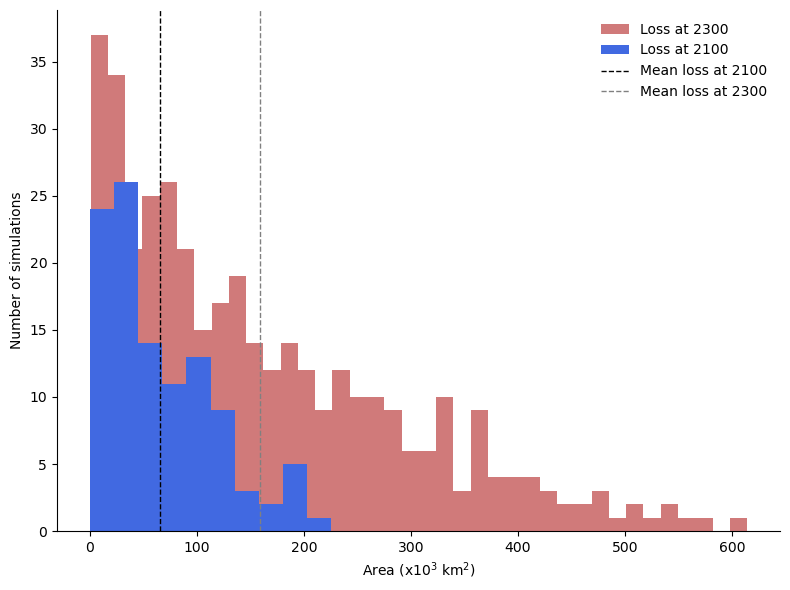

In [45]:
frac_loss = (frac_baseline_amazon - np.mean(frac_models)) * amazon_area / 1e6
frac_loss_l = (frac_baseline_amazon - np.mean(frac_models_l)) * amazon_area / 1e6
print(f'Amazon area = {amazon_area/1e6}')
print(f'Average loss at 2100: {frac_loss} ({(frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {frac_loss_l} ({(frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')

min_loss = (frac_baseline_amazon - np.max(frac_models)) * amazon_area / 1e6
min_loss_l = (frac_baseline_amazon - np.max(frac_models_l)) * amazon_area / 1e6 
max_loss = (frac_baseline_amazon - np.min(frac_models)) * amazon_area / 1e6
max_loss_l = (frac_baseline_amazon - np.min(frac_models_l)) * amazon_area / 1e6 
print(f'Max loss at 2100: {max_loss}')
print(f'Max loss at 2300: {max_loss_l}')
print(f'Min loss at 2100: {min_loss}')
print(f'Min loss at 2300: {min_loss_l}')

num_in_bins = 10
num_bins_l = int(len(frac_models_l) / num_in_bins)
num_bins = int(len(frac_models) / num_in_bins)

fig, ax = plt.subplots(figsize=(8, 6))

plt.hist((frac_baseline_amazon - np.array(frac_models_l)) * amazon_area / 1e9, bins=num_bins_l, color='firebrick', label='Loss at 2300', alpha=0.6)
plt.hist((frac_baseline_amazon - np.array(frac_models)) * amazon_area / 1e9, bins=num_bins, color='royalblue', label='Loss at 2100')

plt.axvline(frac_loss/1e3, color='black', linestyle='--', lw=1, label='Mean loss at 2100')
plt.axvline(frac_loss_l/1e3, color='gray', linestyle='--', lw=1, label='Mean loss at 2300')

plt.xlabel('Area (x10$^3$ km$^2$)')
plt.ylabel('Number of simulations')
plt.legend(loc='upper right', frameon=False)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('../paper_plots/loss_dist.png', dpi=400)

Average loss at 2100: 62785.347674950666 (0.73% decrease)
Average loss at 2100: 69952.98824962437 (0.82% decrease)
Average loss at 2100: 62934.36651236557 (0.73% decrease)
Average loss at 2300: 169051.61393587865 (1.97% decrease)
Average loss at 2300: 142412.69773225056 (1.66% decrease)
Average loss at 2300: 176328.0955157944 (2.06% decrease)


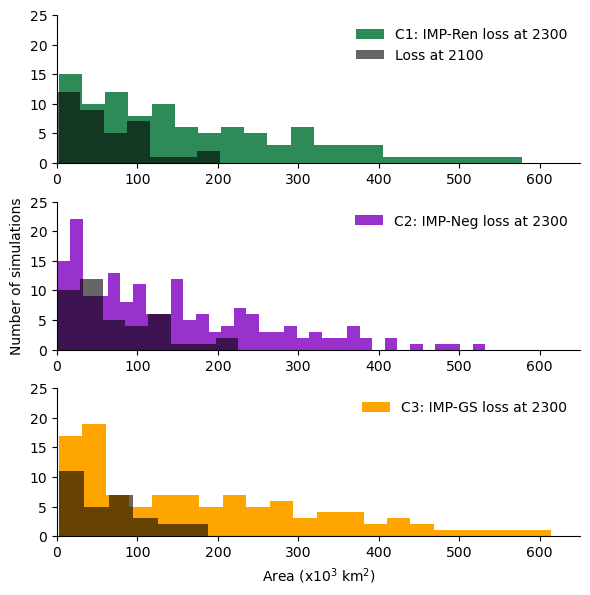

In [46]:
c1_frac_loss = (frac_baseline_amazon - np.mean(c1_frac_models)) * amazon_area / 1e6
c2_frac_loss = (frac_baseline_amazon - np.mean(c2_frac_models)) * amazon_area / 1e6
c3_frac_loss = (frac_baseline_amazon - np.mean(c3_frac_models)) * amazon_area / 1e6

c1_frac_loss_l = (frac_baseline_amazon - np.mean(c1_frac_models_l)) * amazon_area / 1e6
c2_frac_loss_l = (frac_baseline_amazon - np.mean(c2_frac_models_l)) * amazon_area / 1e6
c3_frac_loss_l = (frac_baseline_amazon - np.mean(c3_frac_models_l)) * amazon_area / 1e6

print(f'Average loss at 2100: {c1_frac_loss} ({(c1_frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2100: {c2_frac_loss} ({(c2_frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2100: {c3_frac_loss} ({(c3_frac_loss*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {c1_frac_loss_l} ({(c1_frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {c2_frac_loss_l} ({(c2_frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')
print(f'Average loss at 2300: {c3_frac_loss_l} ({(c3_frac_loss_l*1e6/amazon_area) * 100:.2f}% decrease)')

num_in_bins2 = 5

c1_num_bins = int(len(c1_frac_models) / num_in_bins2)
c2_num_bins = int(len(c2_frac_models) / num_in_bins2)
c3_num_bins = int(len(c3_frac_models) / num_in_bins2)

c1_num_bins_l = int(len(c1_frac_models_l) / num_in_bins2)
c2_num_bins_l = int(len(c2_frac_models_l) / num_in_bins2)
c3_num_bins_l = int(len(c3_frac_models_l) / num_in_bins2)

fig = plt.figure(figsize=(6, 6))

ax = fig.add_subplot(311)

plt.hist((frac_baseline_amazon - np.array(c1_frac_models_l)) * amazon_area / 1e9, bins=c1_num_bins_l, color='seagreen', label='C1: IMP-Ren loss at 2300')
plt.hist((frac_baseline_amazon - np.array(c1_frac_models)) * amazon_area / 1e9, bins=c1_num_bins, color='black', alpha=0.6, label='Loss at 2100')

ax.set_xlim(0, 650)
ax.set_ylim(0, 25)
ax.legend(loc='upper right', frameon=False)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(312)

plt.hist((frac_baseline_amazon - np.array(c2_frac_models_l)) * amazon_area / 1e9, bins=c2_num_bins_l, color='darkorchid', label='C2: IMP-Neg loss at 2300')
plt.hist((frac_baseline_amazon - np.array(c2_frac_models)) * amazon_area / 1e9, bins=c2_num_bins, color='black', alpha=0.6)

ax.set_ylabel('Number of simulations')
ax.set_xlim(0, 650)
ax.set_ylim(0, 25)
ax.legend(loc='upper right', frameon=False)
ax.spines[['right', 'top']].set_visible(False)

ax = fig.add_subplot(313)

plt.hist((frac_baseline_amazon - np.array(c3_frac_models_l)) * amazon_area / 1e9, bins=c3_num_bins_l, color='orange', label='C3: IMP-GS loss at 2300')
plt.hist((frac_baseline_amazon - np.array(c3_frac_models)) * amazon_area / 1e9, bins=c3_num_bins, color='black', alpha=0.6)

ax.set_xlim(0, 650)
ax.set_ylim(0, 25)

ax.set_xlabel('Area (x10$^3$ km$^2$)')
ax.legend(loc='upper right', frameon=False)
plt.tight_layout()
ax.spines[['right', 'top']].set_visible(False)
plt.savefig('../paper_plots/loss_dist_sep.png', dpi=400)

In [ ]:
frac_baseline_amazon

In [90]:
# Calculate probably of loss regardless of danger zone

exceed_2100 = [c1_frac_models, c2_frac_models, c3_frac_models]
exceed_2300 = [c1_frac_models_l, c2_frac_models_l, c3_frac_models_l]
not_exceed_2100 = [c1_frac_not_2100, c2_frac_not_2100, c3_frac_not_2100]
not_exceed_2300 = [c1_frac_not_2300, c2_frac_not_2300, c3_frac_not_2300]

for i, scen in enumerate(scenarios):
    exceedence_prob_2100 = (len(exceed_2100[i]) / (len(exceed_2100[i]) + len(not_exceed_2100[i]))) * 100
    exceedence_prob_2300 = (len(exceed_2300[i]) / (len(exceed_2300[i]) + len(not_exceed_2300[i]))) * 100
    print(f'Probability of {scen} exceeding by 2100: {exceedence_prob_2100}')
    print(f'Probability of {scen} exceeding by 2300: {exceedence_prob_2300}')
    
    print(f'Number of models exceeding by 2100 in {scen}: {len(exceed_2100[i])}')
    print(f'Number of models exceeding by 2300 in {scen}: {len(exceed_2300[i])}\n')
    
hist = np.array([[len(exceed_2100[0]), len(exceed_2300[0])], [len(exceed_2100[1]), len(exceed_2300[1])], [len(exceed_2100[2]), len(exceed_2300[2])]])

Probability of C1-IMP-Ren exceeding by 2100: 12.091503267973856
Probability of C1-IMP-Ren exceeding by 2300: 33.006535947712415
Number of models exceeding by 2100 in C1-IMP-Ren: 37
Number of models exceeding by 2300 in C1-IMP-Ren: 101

Probability of C2-IMP-Neg exceeding by 2100: 13.398692810457517
Probability of C2-IMP-Neg exceeding by 2300: 56.5359477124183
Number of models exceeding by 2100 in C2-IMP-Neg: 41
Number of models exceeding by 2300 in C2-IMP-Neg: 173

Probability of C3-IMP-GS exceeding by 2100: 9.803921568627452
Probability of C3-IMP-GS exceeding by 2300: 35.294117647058826
Number of models exceeding by 2100 in C3-IMP-GS: 30
Number of models exceeding by 2300 in C3-IMP-GS: 108



In [110]:
level_frac = 0.95

# Collect models which exceed but don't go below 10% of present-day level
c1_frac_models_med = np.array([x for x in c1_frac_models if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c2_frac_models_med = np.array([x for x in c2_frac_models if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c3_frac_models_med = np.array([x for x in c3_frac_models if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])

# Collect models which go below 10% of present-day level
c1_frac_models_big = np.array([x for x in c1_frac_models if x <= frac_baseline_amazon*level_frac]) 
c2_frac_models_big = np.array([x for x in c2_frac_models if x <= frac_baseline_amazon*level_frac]) 
c3_frac_models_big = np.array([x for x in c3_frac_models if x <= frac_baseline_amazon*level_frac]) 

big_exceed_2100 = [c1_frac_models_big, c2_frac_models_big, c3_frac_models_big]
med_exceed_2100 = [c1_frac_models_med, c2_frac_models_med, c3_frac_models_med]

for i, scen in enumerate(scenarios):
    exceedence_prob_2100 = (len(big_exceed_2100[i]) / (len(big_exceed_2100[i]) + len(med_exceed_2100[i]) + len(not_exceed_2100[i]))) * 100
    print(f'Probability of {scen} exceeding by 2100: {exceedence_prob_2100}')

Probability of C1-IMP-Ren exceeding by 2100: 0.6535947712418301
Probability of C2-IMP-Neg exceeding by 2100: 0.9803921568627451
Probability of C3-IMP-GS exceeding by 2100: 0.32679738562091504


In [105]:
level_frac = 0.9

# Collect models which exceed but don't go below 10% of present-day level
c1_frac_models_med = np.array([x for x in c1_frac_models_l if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c2_frac_models_med = np.array([x for x in c2_frac_models_l if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])
c3_frac_models_med = np.array([x for x in c3_frac_models_l if (x > frac_baseline_amazon*level_frac) & (x < frac_baseline_amazon)])

# Collect models which go below 10% of present-day level
c1_frac_models_big_l = np.array([x for x in c1_frac_models_l if x <= frac_baseline_amazon*level_frac]) 
c2_frac_models_big_l = np.array([x for x in c2_frac_models_l if x <= frac_baseline_amazon*level_frac]) 
c3_frac_models_big_l = np.array([x for x in c3_frac_models_l if x <= frac_baseline_amazon*level_frac]) 

big_exceed_2300 = [c1_frac_models_big_l, c2_frac_models_big_l, c3_frac_models_big_l]
med_exceed_2300 = [c1_frac_models_med, c2_frac_models_med, c3_frac_models_med]

for i, scen in enumerate(scenarios):
    exceedence_prob_2300 = (len(big_exceed_2300[i]) / (len(big_exceed_2300[i]) + len(med_exceed_2300[i]) + len(not_exceed_2300[i]))) * 100
    print(f'Probability of {scen} exceeding by 2300: {exceedence_prob_2300}')

Probability of C1-IMP-Ren exceeding by 2300: 3.9215686274509802
Probability of C2-IMP-Neg exceeding by 2300: 3.9215686274509802
Probability of C3-IMP-GS exceeding by 2300: 5.228758169934641


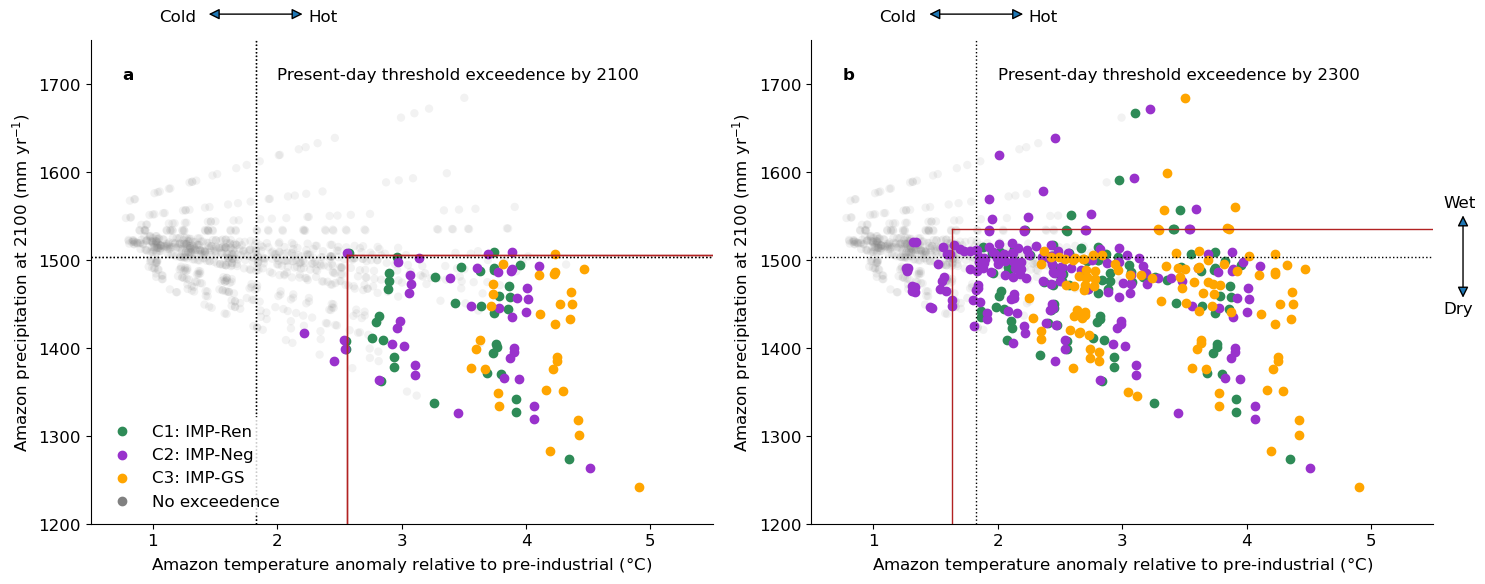

In [33]:
matplotlib.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(15, 6))
# gs = fig.add_gridspec(2, 2, height_ratios=[5, 1])

ax = fig.add_subplot(1, 2, 1)

# Greyed out points
ax.scatter(not_temps, np.array(not_precip)*60*60*24*360, color='grey', alpha=0.1, edgecolor='none')

# Climatic zones
ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[0,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp,twosig_temp+10],[twosig_precip*60*60*24*360,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)

# ax.plot([lower_temp, lower_temp], [0, 1650], color='firebrick', lw=1.0)
# ax.plot([upper_temp, upper_temp], [0, 1650], color='firebrick', lw=1.0)

# Exceedence points
ax.scatter(c1_temp_frac_models, np.array(c1_precip_frac_models)*60*60*24*360, color='seagreen', label='C1: IMP-Ren')
ax.scatter(c2_temp_frac_models, np.array(c2_precip_frac_models)*60*60*24*360, color='darkorchid', label='C2: IMP-Neg')
ax.scatter(c3_temp_frac_models, np.array(c3_precip_frac_models)*60*60*24*360, color='orange', label='C3: IMP-GS')

ax.scatter(-9, -9, color='grey', label='No exceedence')

ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[0,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp,twosig_temp+10],[twosig_precip*60*60*24*360,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)

ax.set_xlabel('Amazon temperature anomaly relative to pre-industrial ($\degree$C)')
ax.set_ylabel('Amazon precipitation at 2100 (mm yr$^{-1}$)')
ax.set_xlim([0.5, 5.5])
ax.set_ylim([1200, 1750])
ax.text(0.05, 0.92, 'a', transform=ax.transAxes, color='black', weight='bold')
ax.text(0.30, 0.92, 'Present-day threshold exceedence by 2100', transform=ax.transAxes, color='black')
ax.legend(loc='lower left', edgecolor='none')
ax.spines[['right', 'top']].set_visible(False)

p1 = patches.FancyArrowPatch((mean_temp-0.4, 1780), (mean_temp+0.4, 1780), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p1)
ax.text(mean_temp + 0.42, 1772, 'Hot', color='black')
ax.text(mean_temp - 0.78, 1772, 'Cold', color='black')

# ax2 = ax.twiny()

# ax2.scatter((np.array(not_temps), np.array(not_precip)*60*60*24*360, color='grey', alpha=1, edgecolor='none')
# ax2.scatter(np.array(c1_temp_frac_models)/m, np.array(c1_precip_frac_models)*60*60*24*360, alpha=0, color='seagreen')
# ax2.scatter(np.array(c2_temp_frac_models)/m, np.array(c2_precip_frac_models)*60*60*24*360, alpha=0, color='darkorchid')
# ax2.scatter(np.array(c3_temp_frac_models)/m, np.array(c3_precip_frac_models)*60*60*24*360, alpha=0, color='orange')

# ax.axvline(2.557)
ax = fig.add_subplot(1, 2, 2)

# Greyed out points
ax.scatter(not_temps, np.array(not_precip)*60*60*24*360, color='grey', alpha=0.1, edgecolor='none')

# Climatic zones 
ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l],[0,twosig_precip_l*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l+10],[twosig_precip_l*60*60*24*360,twosig_precip_l*60*60*24*360], color='firebrick', lw=1.0)

# ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
# ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
# ax.plot([lower_temp, lower_temp], [0, 1650], color='firebrick', lw=1.0)
# ax.plot([upper_temp, upper_temp], [0, 1650], color='firebrick', lw=1.0)

# Exceedence points
ax.scatter(c1_temp_frac_models_l, np.array(c1_precip_frac_models_l)*60*60*24*360, color='seagreen')
ax.scatter(c2_temp_frac_models_l, np.array(c2_precip_frac_models_l)*60*60*24*360, color='darkorchid')
ax.scatter(c3_temp_frac_models_l, np.array(c3_precip_frac_models_l)*60*60*24*360, color='orange')

ax.set_xlabel('Amazon temperature anomaly relative to pre-industrial ($\degree$C)')
ax.set_ylabel('Amazon precipitation at 2100 (mm yr$^{-1}$)')
ax.set_xlim([0.5, 5.5])
ax.set_ylim([1200, 1750])
ax.text(0.05, 0.92, 'b', transform=ax.transAxes, color='black', weight='bold')
ax.text(0.30, 0.92, 'Present-day threshold exceedence by 2300', transform=ax.transAxes, color='black')
ax.spines[['right', 'top']].set_visible(False)

p1 = patches.FancyArrowPatch((mean_temp-0.4, 1780), (mean_temp+0.4, 1780), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p1)
ax.text(mean_temp + 0.42, 1772, 'Hot', color='black')
ax.text(mean_temp - 0.78, 1772, 'Cold', color='black')

p2 = patches.FancyArrowPatch((5.74, mean_precip*60*60*24*360 - 50), (5.74, mean_precip*60*60*24*360 + 50), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p2)
ax.text(5.58, mean_precip*60*60*24*360 + 56, 'Wet', color='black')
ax.text(5.58, mean_precip*60*60*24*360 - 64, 'Dry', color='black')

# ax = fig.add_subplot(gs[1, :])

# for scen in scenarios:
#     for p in percentiles:
#         ax.scatter(global_temps, amazon_temps, color='k', marker='o', s=8, alpha=0.01)

# ax.plot(global_temps, y, color='r', lw=1, alpha=0.8)
# ax.set_xlabel('GMST anomaly relative to pre-industrial ($\degree$C)')
# ax.set_ylabel('Amazon temperature ($\degree$C)')

plt.tight_layout()
plt.savefig('../paper_plots/exceedence_distributions_op1.png', dpi=400)

In [33]:
twosig_temp / m

2.1390185977828065

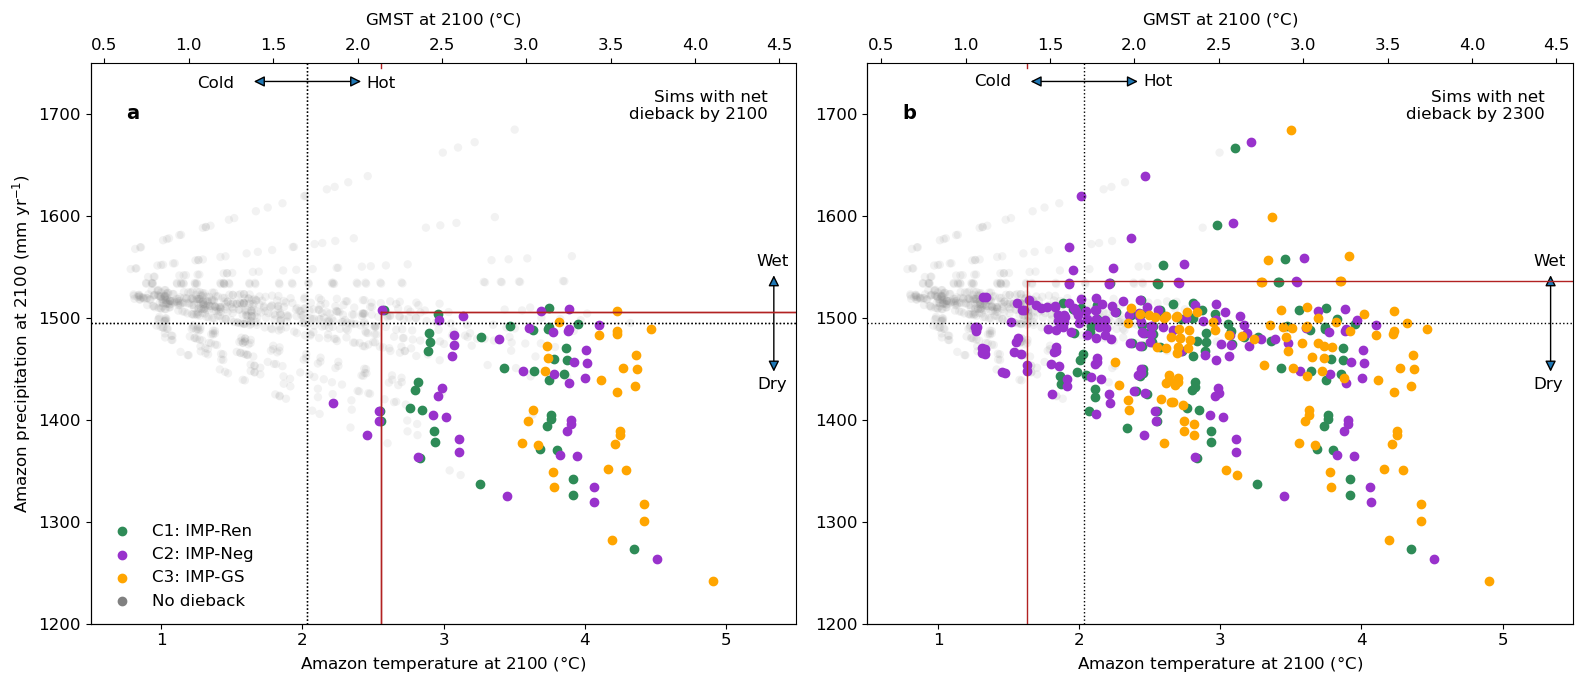

In [49]:
matplotlib.rcParams.update({'font.size': 12})

fig = plt.figure(figsize=(16, 7))
# gs = fig.add_gridspec(2, 2, height_ratios=[5, 1])

ax = fig.add_subplot(1, 2, 1)

# Greyed out points
ax.scatter(not_temps, np.array(not_precip)*60*60*24*360, color='grey', alpha=0.1, edgecolor='none')

# Climatic zones
ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[0,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp,twosig_temp+10],[twosig_precip*60*60*24*360,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)

# ax.plot([lower_temp, lower_temp], [0, 1650], color='firebrick', lw=1.0)
# ax.plot([upper_temp, upper_temp], [0, 1650], color='firebrick', lw=1.0)

# Exceedence points
ax.scatter(c1_temp_frac_models, np.array(c1_precip_frac_models)*60*60*24*360, color='seagreen', label='C1: IMP-Ren')
ax.scatter(c2_temp_frac_models, np.array(c2_precip_frac_models)*60*60*24*360, color='darkorchid', label='C2: IMP-Neg')
ax.scatter(c3_temp_frac_models, np.array(c3_precip_frac_models)*60*60*24*360, color='orange', label='C3: IMP-GS')

ax.scatter(-9, -9, color='grey', label='No dieback')

ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[0,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp,twosig_temp+10],[twosig_precip*60*60*24*360,twosig_precip*60*60*24*360], color='firebrick', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp,twosig_temp],[1745,1750], color='firebrick', lw=1.0)

ax.set_xlabel('Amazon temperature at 2100 ($\degree$C)')
ax.set_ylabel('Amazon precipitation at 2100 (mm yr$^{-1}$)')
ax.set_xlim([0.5, 5.5])
ax.set_ylim([1200, 1750])
ax.text(0.05, 0.90, 'a', transform=ax.transAxes, color='black', weight='bold', fontsize=14)
ax.text(0.96, 0.90, 'Sims with net\ndieback by 2100', transform=ax.transAxes, color='black', ha='right')
ax.legend(loc='lower left', edgecolor='none')
ax.spines[['right', 'top']].set_visible(False)

p1 = patches.FancyArrowPatch((mean_temp-0.4, 1732), (mean_temp+0.4, 1732), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p1)
ax.text(mean_temp + 0.42, 1726, 'Hot', color='black')
ax.text(mean_temp - 0.78, 1726, 'Cold', color='black')

p2 = patches.FancyArrowPatch((5.34, mean_precip*60*60*24*360 - 50), (5.34, mean_precip*60*60*24*360 + 50), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p2)
ax.text(5.22, mean_precip*60*60*24*360 + 56, 'Wet', color='black')
ax.text(5.22, mean_precip*60*60*24*360 - 64, 'Dry', color='black')

ax2 = ax.twiny()

ax2.scatter(np.array(not_temps), np.array(not_precip)*60*60*24*360, color='grey', alpha=0, edgecolor='none')
ax2.scatter(np.array(c1_temp_frac_models)/m, np.array(c1_precip_frac_models)*60*60*24*360, alpha=0, color='seagreen')
ax2.scatter(np.array(c2_temp_frac_models)/m, np.array(c2_precip_frac_models)*60*60*24*360, alpha=0, color='darkorchid')
ax2.scatter(np.array(c3_temp_frac_models)/m, np.array(c3_precip_frac_models)*60*60*24*360, alpha=0, color='orange')
ax2.set_xlabel('GMST at 2100 ($\degree$C)', labelpad=10)
ax2.set_xlim([0.5/m, 5.5/m])

# ax.axvline(2.557)
ax = fig.add_subplot(1, 2, 2)

# Greyed out points
ax.scatter(not_temps, np.array(not_precip)*60*60*24*360, color='grey', alpha=0.1, edgecolor='none')

# Climatic zones 
ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l],[0,twosig_precip_l*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l+10],[twosig_precip_l*60*60*24*360,twosig_precip_l*60*60*24*360], color='firebrick', lw=1.0)
ax.plot([twosig_temp_l,twosig_temp_l],[1745,1750], color='firebrick', lw=1.0)

# ax.axvline(mean_temp, linestyle=':', color='black', lw=1.0)
# ax.axhline(mean_precip*60*60*24*360, linestyle=':', color='black', lw=1.0)
# ax.plot([lower_temp, lower_temp], [0, 1650], color='firebrick', lw=1.0)
# ax.plot([upper_temp, upper_temp], [0, 1650], color='firebrick', lw=1.0)

# Exceedence points
ax.scatter(c1_temp_frac_models_l, np.array(c1_precip_frac_models_l)*60*60*24*360, color='seagreen')
ax.scatter(c2_temp_frac_models_l, np.array(c2_precip_frac_models_l)*60*60*24*360, color='darkorchid')
ax.scatter(c3_temp_frac_models_l, np.array(c3_precip_frac_models_l)*60*60*24*360, color='orange')

ax.set_xlabel('Amazon temperature at 2100 ($\degree$C)')
# ax.set_ylabel('Amazon precipitation at 2100 (mm yr$^{-1}$)')
ax.set_xlim([0.5, 5.5])
ax.set_ylim([1200, 1750])
ax.text(0.05, 0.90, 'b', transform=ax.transAxes, color='black', weight='bold', fontsize=14)
ax.text(0.96, 0.90, 'Sims with net\ndieback by 2300', transform=ax.transAxes, color='black', ha='right')
ax.spines[['right', 'top']].set_visible(False)

p1 = patches.FancyArrowPatch((mean_temp-0.4, 1732), (mean_temp+0.4, 1732), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p1)
ax.text(mean_temp + 0.42, 1728, 'Hot', color='black')
ax.text(mean_temp - 0.78, 1728, 'Cold', color='black')

p2 = patches.FancyArrowPatch((5.34, mean_precip*60*60*24*360 - 50), (5.34, mean_precip*60*60*24*360 + 50), arrowstyle='<|-|>', clip_on=False, mutation_scale=16)
ax.add_patch(p2)
ax.text(5.22, mean_precip*60*60*24*360 + 56, 'Wet', color='black')
ax.text(5.22, mean_precip*60*60*24*360 - 64, 'Dry', color='black')

ax2 = ax.twiny()

ax2.scatter(np.array(not_temps), np.array(not_precip)*60*60*24*360, color='grey', alpha=0, edgecolor='none')
ax2.scatter((np.array(c1_temp_frac_models_l)/m), np.array(c1_precip_frac_models_l)*60*60*24*360, alpha=0, color='seagreen')
ax2.scatter((np.array(c2_temp_frac_models_l)/m), np.array(c2_precip_frac_models_l)*60*60*24*360, alpha=0, color='darkorchid')
ax2.scatter((np.array(c3_temp_frac_models_l)/m), np.array(c3_precip_frac_models_l)*60*60*24*360, alpha=0, color='orange')
ax2.set_xlim([0.5/m, 5.5/m])

ax2.set_xlabel('GMST at 2100 ($\degree$C)', labelpad=10)

# ax = fig.add_subplot(gs[1, :])

# for scen in scenarios:
#     for p in percentiles:
#         ax.scatter(global_temps, amazon_temps, color='k', marker='o', s=8, alpha=0.01)

# ax.plot(global_temps, y, color='r', lw=1, alpha=0.8)
# ax.set_xlabel('GMST anomaly relative to pre-industrial ($\degree$C)')
# ax.set_ylabel('Amazon temperature ($\degree$C)')

plt.tight_layout()
plt.savefig('../paper_plots/exceedence_distributions_op2.png', dpi=400)